# Practical Machine Learning for Physicists
# Double Pendulum Research Note

We will set up the equations of motions for a simple double pendulum (or should that be a double simple pendulum. Then we will see if a machine learning technique can predict the future position of the lower mass, using only the lower mass positions.

### Kinematics of the double pendulum
Let's specify our problem in terms of the following, with the origin at the pivot point of the top pendulum. This is just background for the machine learning tasks at the bottom of the notebook.

#### Positions
$$x_1 = L_1 \sin \theta_1$$
$$y_1 = -L_1 \cos \theta_1$$
$$x_2 = x_1 + L_2 \sin \theta_2$$
$$y_2 = y_1 - L_2 \cos \theta_2$$

#### Velocities
$$\dot{x}_1 = \dot{\theta_1} L_1 \cos \theta_1$$
$$\dot{y_1} =  \dot{\theta_1} L_1 \sin \theta_1$$
$$\dot{x_2} = \dot{x_1} + \dot{\theta_2} L_2 \cos \theta_2$$
$$\dot{y_2} = \dot{y_1} + \dot{\theta_2} L_2 \sin \theta_2$$


#### Accelerations

$$\ddot{x}_1 = -\dot{\theta_1}^2 L_1 \sin \theta_1 + \ddot{\theta_1} L_1 \cos \theta_1$$
$$\ddot{y_1} =  \dot{\theta_1}^2 L_1 \cos \theta_1 + \ddot{\theta_1} L_1 \sin \theta_1$$
$$\ddot{x_2} = \ddot{x_1} - \dot{\theta_2}^2 L_2 \sin \theta_2 + \ddot{\theta_2} L_2 \cos \theta_2$$
$$\ddot{y_2} = \ddot{y_1} + \dot{\theta_2}^2 L_2 \cos \theta_2 + \ddot{\theta_2} L_2 \sin \theta_2$$

#### Energies
Let $v_1^2 = \dot{x_1}^2 +\dot{y_1}^2$ and $v_2^2 = \dot{x_2}^2 +\dot{y_2}^2$ then the kinetic energies $T_1$ and $T_2$ are
$$ T_1 = \frac{1}{2}m_1 v_1^2 = \frac{1}{2}m_1 L_1^2 \dot{\theta_1}^2 $$
$$ T_2 = \frac{1}{2}m_2 v_2^2 = \frac{1}{2}m_2 \left( L_1^2 \dot{\theta_1}^2 + L_2^2 \dot{\theta_2}^2 + 2L_1 L_2 \cos(\theta_1-\theta_2) \dot{\theta_1} \dot{\theta_2} \right) $$

The potential enrgies are
$$V_1 = m_1 g y_1 = - m_1 g L_1 \cos \theta_1$$
$$V_2 = m_2 g y_2 = -m_2 g ( L_1 \cos \theta_1 + L_2 \cos \theta_2)$$

#### Langrangian
Now we form the Lagrangian $L=T-V=T_1+T_2 -V_1 -V_2$ and use the Euler-Lagrange equations:
$$\frac{\partial L}{\partial \theta_1} = \frac{d}{dt}\frac{\partial L}{\partial \dot{\theta_1}}$$
$$\frac{\partial L}{\partial \theta_2} = \frac{d}{dt}\frac{\partial L}{\partial \dot{\theta_2}}$$

Applying these gives
$$-(m_1+m_2) g L_1 \sin \theta_1 = (m_1+m_2) L_1^2 \ddot{\theta_1} + m_2 L_1 L_2 \sin(\theta_1-\theta_2) \dot{\theta_2}^2 +  m_2 L_1 L_2 \cos(\theta_1-\theta_2) \ddot{\theta_2} $$
and
$$ -m_2 g L_2 \sin \theta_2 = m_2 L_2 \ddot{\theta_2} + m_2 L_1 L_2 \cos(\theta_1-\theta_2) \ddot{\theta_1} + m_2 L_1 L_2 \sin(\theta_1-\theta_2) \dot{\theta_1}^2 $$ 


#### Equations of motions
$$ \omega_1 = \dot{\theta_1}$$  

$$ \omega_2 = \dot{\theta_2}$$ 
$$ \ddot\theta_1 = \frac{1}{L_1\xi}\left[L_1m_2\cos(\theta_1-\theta_2)\sin(\theta_1-\theta_2)\omega_1^2 + L_2m_2\sin(\theta_1-\theta_2)\omega_2^2 - m_2g\cos(\theta_1-\theta_2)\sin(\theta_2) + (m_1+m_2)g\sin(\theta_1) \right] $$
$$ \ddot\theta_2 = \frac{1}{L_2\xi}\left[L_2m_2\cos(\theta_1-\theta_2)\sin(\theta_1-\theta_2)\omega_2^2 + L_1(m_1+m_2)\sin(\theta_1-\theta_2)\omega_1^2+(m_1+m_2)g\sin(\theta_1)\cos(\theta_1-\theta_2) - (m_1+m_2)g\sin(\theta_2) \right] $$
where 
$$\xi \equiv \cos^2(\theta_1-\theta_2)m_2-m_1-m_2$$


In [10]:
import numpy as np
import matplotlib.pyplot as plt 
from scipy.integrate import solve_ivp

import matplotlib.style #Some style nonsense
import matplotlib as mpl #Some more style nonsense

from tqdm import tqdm

#Set default figure size
#mpl.rcParams['figure.figsize'] = [12.0, 8.0] #Inches... of course it is inches
mpl.rcParams["legend.frameon"] = False
mpl.rcParams['figure.dpi']=200 # dots per inch



In [2]:
def rhs(t, z, L1, L2, m1, m2, g):
    """
    Returns the right-hand side of the ordinary differential equation describing the double pendulem
    """
    theta1, w1, theta2, w2 = z
    cos12 = np.cos(theta1 - theta2)
    sin12 = np.sin(theta1 - theta2)
    sin1 = np.sin(theta1)
    sin2 = np.sin(theta2)
    xi = cos12**2*m2 - m1 - m2
    w1dot = ( L1*m2*cos12*sin12*w1**2 + L2*m2*sin12*w2**2
            - m2*g*cos12*sin2      + (m1 + m2)*g*sin1)/(L1*xi)
    w2dot = -( L2*m2*cos12*sin12*w2**2 + L1*(m1 + m2)*sin12*w1**2
            + (m1 + m2)*g*sin1*cos12  - (m1 + m2)*g*sin2 )/(L2*xi)
    return w1, w1dot, w2, w2dot


def to_cartesian(theta1, w1, theta2, w2, L1, L2):
    """ Transforms theta and omega to cartesian coordinates
    and velocities x1, y1, x2, y2, vx1, vy1, vx2, vy2
    """
    x1 = L1 * np.sin(theta1)
    y1 = -L1 * np.cos(theta1)
    x2 = x1 + L2 * np.sin(theta2)
    y2 = y1 - L2 * np.cos(theta2)
    vx1 = L1*np.cos(theta1)*w1
    vy1 = L1*np.sin(theta1)*w1
    vx2 = vx1 + L2*np.cos(theta2)*w2
    vy2 = vy1 + L2*np.sin(theta2)*w2
    return x1, y1, x2, y2, vx1, vy1, vx2, vy2
    

In [27]:
L1, L2 = 1.0, 1.0
m1, m2 = 3., 1.
g = 9.81     # [m/s^2]. Gravitational acceleration

z0=[np.pi,0,np.pi,0]
#z0=[0.1,0,0.1,0]
tmax, dt = 50, 0.01
t = np.arange(0, tmax+dt, dt)

In [28]:
# Solve initial value problem
ret = solve_ivp(rhs, (0,tmax), z0, t_eval=t, args=(L1, L2, m1, m2, g))

z=ret.y
print(np.shape(z))

# Extract result
theta1, w1, theta2, w2 = z[0], z[1], z[2], z[3]
x1, y1, x2, y2, vx1, vy1, vx2, vy2 = to_cartesian(theta1, w1, theta2, w2, L1, L2)

(4, 5001)


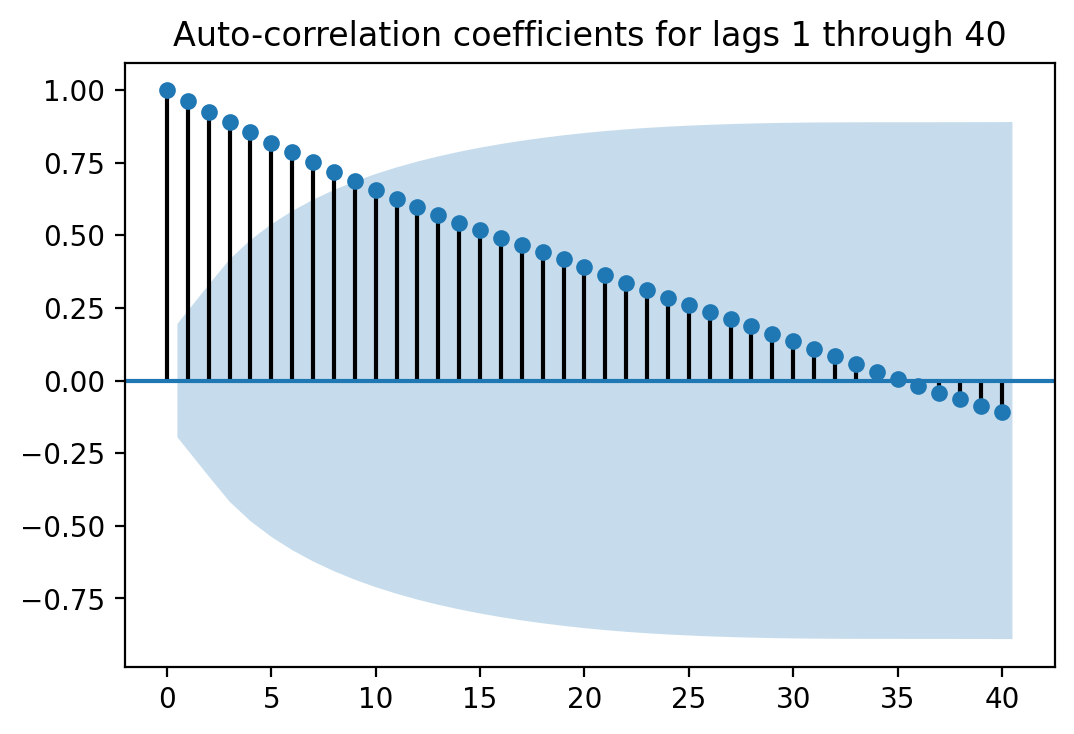

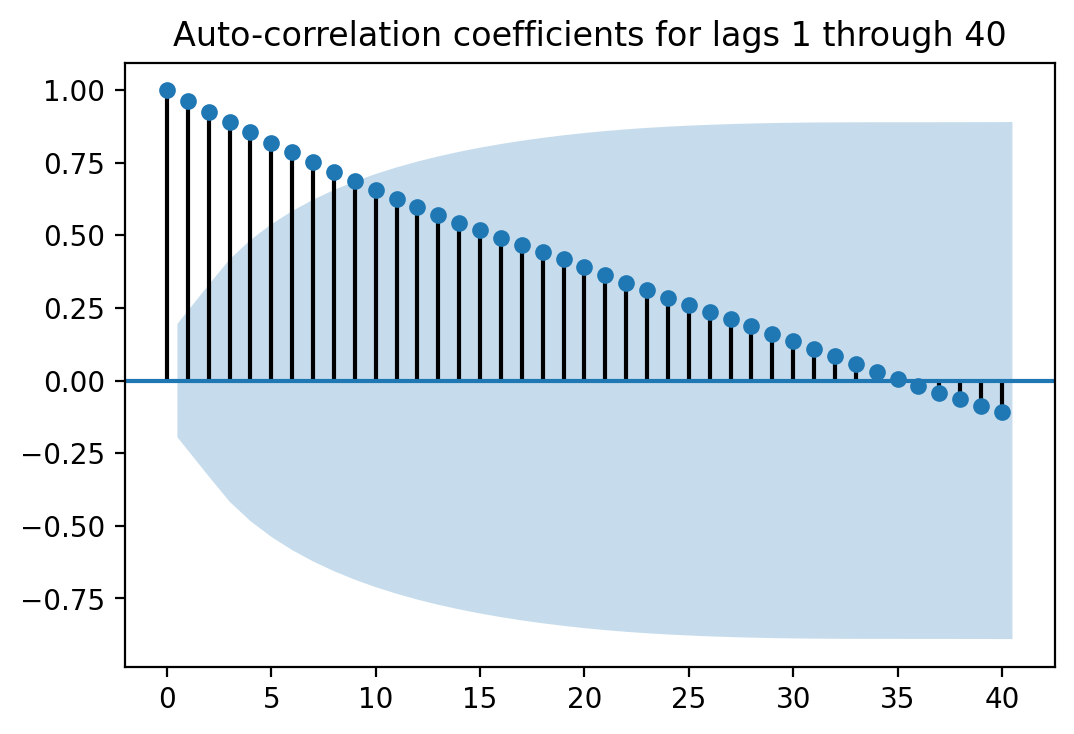

In [41]:
import statsmodels.graphics.tsaplots as tsa
tsa.plot_acf(theta2[::50], lags=40, alpha=0.05, title='Auto-correlation coefficients for lags 1 through 40')

In [39]:
import statsmodels.stats.diagnostic as diag
diag.acorr_ljungbox(theta2[::50], lags=[50], boxpierce=True, model_df=0, period=None, return_df=False)

(array([1211.01475564]),
 array([1.06458766e-220]),
 array([1046.04956907]),
 array([2.11548253e-186]))

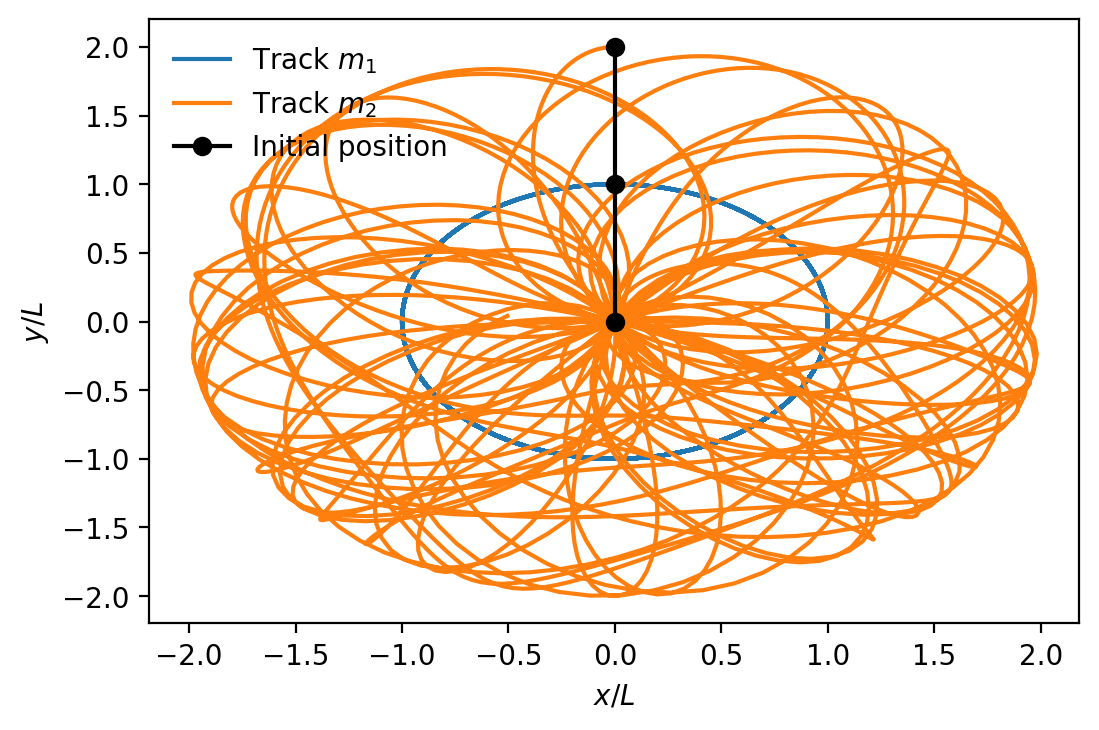

In [30]:
fig,ax=plt.subplots()
ax.plot(x1, y1, label=r"Track $m_1$")
ax.plot(x2, y2, label=r"Track $m_2$")
ax.plot([0, x1[0], x2[0]], [0, y1[0], y2[0]], "-o", label="Initial position", c='k')
plt.ylabel(r"$y/L$")
plt.xlabel(r"$x/L$")
ax.legend()
plt.show()

# Exercises: Predicting Chaos
1. Design and train a recurrent neural network (of your choice) to predict the future positions, where future is defined as $t=t_0 + 20 \delta t$, of the masses $m_1$ and $m_2$ using their cartesian coordinates and the initial conditions  $z_0=[\pi/4,0,\pi/4,0]$. 
2. How stable is your network to variations in initial conditions? Make a plot to show the network prediction in comparison to the solution from solve_ivp
3. How far into the future can a network predict? Make a plot showing how the deviation between predicted position and actual position (from solve_ivp above) vary as a function of extrapolation time from $t=t_0 + 20 \delta t$ to $t=t_0 + 100 \delta t$  (e.g. for each extrapolation time, train a new version of the network and then plot the performance)
4. Repeat steps 1-3 for the initial conditions $z_0=[\pi/2,0,\pi/2,0]$ which give a much more complex path.
5. Repeat steps 1-4 but only train your neural network on the cartesian coordinates of the mass $m_2$ (i.e without showing your neural network the positions of the mass $m_1$)



# Task 1: 
Design and train a recurrent neural network (of your choice) to predict the future positions, where future is defined as $t=t_0 + 20 \delta t$, of the masses $m_1$ and $m_2$ using their cartesian coordinates and the initial conditions  $z_0=[\pi/4,0,\pi/4,0]$. 

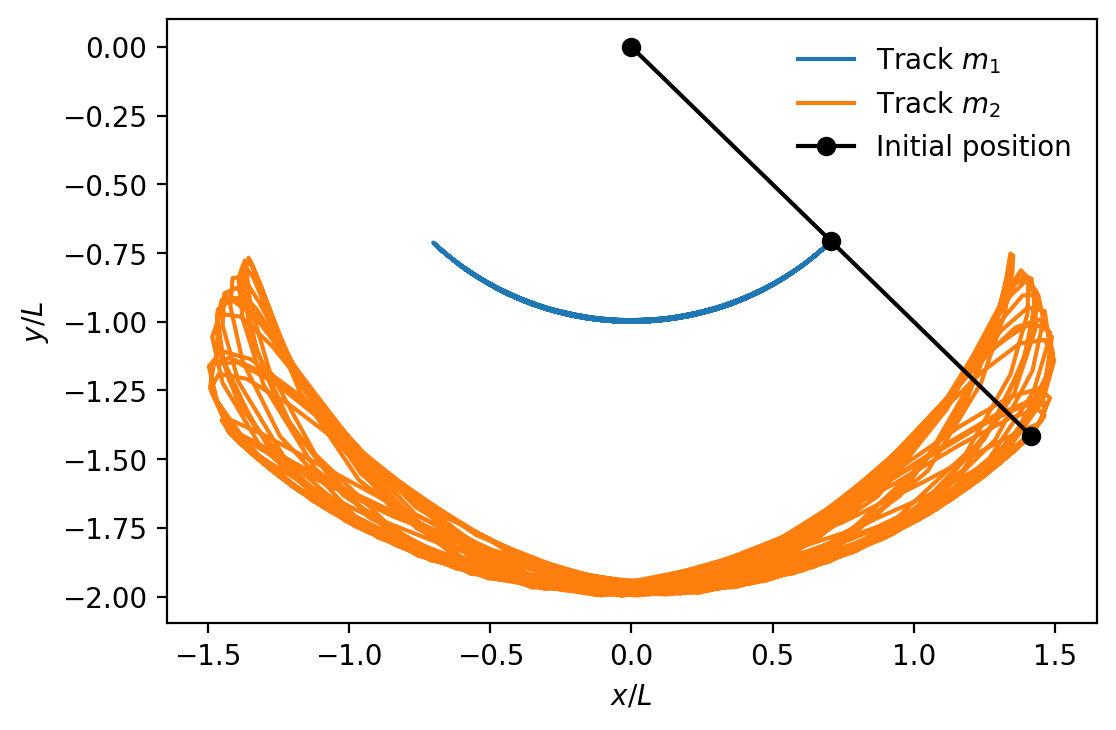

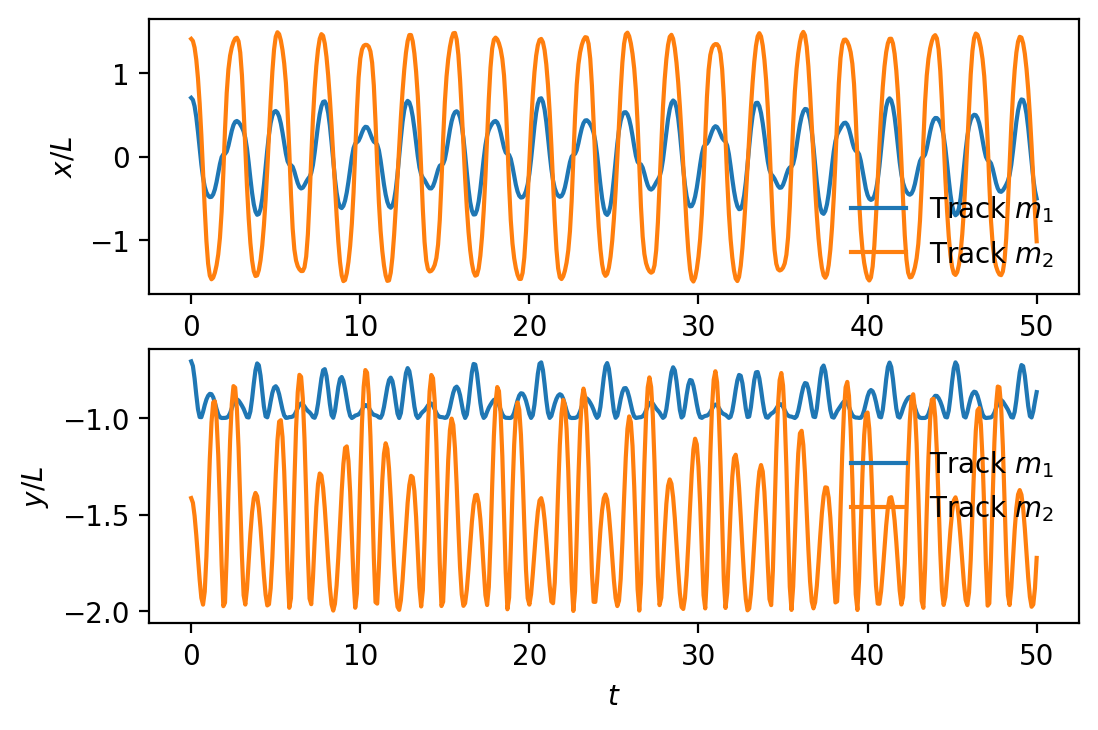

In [6]:
def getTXY(z0,tmax,dt):
    # Get time vlaues
    t = np.arange(0, tmax+dt, dt)
    
    # Solve initial value problem
    ret = solve_ivp(rhs, (0,tmax), z0, t_eval=t, args=(L1, L2, m1, m2, g))
    z=ret.y

    # Extract result
    theta1, w1, theta2, w2 = z[0], z[1], z[2], z[3]
    x1, y1, x2, y2, vx1, vy1, vx2, vy2 = to_cartesian(theta1, w1, theta2, w2, L1, L2)
    return t,x1,y1,x2,y2

# First step is just to set up the problem and plot things
# For the first task we get to use the easy starting conditions
z0=[np.pi/4,0,np.pi/4,0]
#z0=[0.1,0,0.1,0]
tmax, dt = 50, 0.1

t,x1,y1,x2,y2=getTXY(z0,tmax,dt)

fig,ax=plt.subplots()
ax.plot(x1, y1, label=r"Track $m_1$")
ax.plot(x2, y2, label=r"Track $m_2$")
ax.plot([0, x1[0], x2[0]], [0, y1[0], y2[0]], "-o", label="Initial position", c='k')
plt.ylabel(r"$y/L$")
plt.xlabel(r"$x/L$")
ax.legend()


fig,ax=plt.subplots(2,1)
ax[0].plot(t, x1, label=r"Track $m_1$")
ax[0].plot(t, x2, label=r"Track $m_2$")
ax[0].set_ylabel(r"$x/L$")
ax[0].set_xlabel(r"$t$")
ax[0].legend()
ax[1].plot(t, y1, label=r"Track $m_1$")
ax[1].plot(t, y2, label=r"Track $m_2$")
ax[1].set_ylabel(r"$y/L$")
ax[1].set_xlabel(r"$t$")
ax[1].legend()


#### Reshape our data for machine learning
Next we need to reshape our data such that it is suitable for training our network

In [7]:
#Try normalising data, not sure if this will work since it is taking information
# about pendulum lengths away
#x1max=np.max(np.abs(x1))
#x2max=np.max(np.abs(x2))
#y1max=np.max(np.abs(y1))
#y2max=np.max(np.abs(y2))
#x1/=x1max
#y1/=y1max
#x2/=x2max
#y2/=y2max
# it didn't work

from sklearn.model_selection import train_test_split

#This function splits up a 1-d array x into a series of overlapping windows
#The return is a tuple of the array of input windows and target (label) windows
def shapeArray(x,windowsize,offset):
    xInput= np.array([x[i : i + windowsize] for i in range(len(x)-(windowsize+offset)+1)])
    xLabel= np.array([x[i +windowsize : i+ windowsize+offset] for i in range(len(x)-(windowsize+offset)+1)])
    return (xInput,xLabel)

def getTestTrainVal(data,windowsize,offset):
    # Now we use our shapeArray function to make the training sequences
    shapedata,shapelabel=shapeArray(data,windowsize,offset)
    shapelabel=shapelabel[:,-1,:]
    #print(shapedata.shape,shapelabel.shape)

    # Lastly we split out data in training, validation and testing
    # Keep the last 100 sequences for testing
    test_data=shapedata[-100:]
    test_label=shapelabel[-100:]
    train_data, val_data, train_label, val_label = train_test_split(shapedata[0:-100], shapelabel[0:-100], random_state = 0)
    #print(train_data.shape,train_label.shape,val_data.shape,val_label.shape)
    return train_data,val_data,test_data,train_label,val_label,test_label
    
# Here we stack the 1D arrays to make a 2D array (the .T is to transpose it from 4 arrays of 501 values
# to 501 arrays of 4 values)

windowsize=50 #Number of samples we will use to train our network
offset=20 #How many samples into the future to predict
data=np.vstack([x1,y1,x2,y2]).T
print(data.shape)
train_data,val_data,test_data,train_label,val_label,test_label=getTestTrainVal(data,windowsize,offset)

(501, 4)


### Design our prediction network

In [8]:
# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras

def create_model(num_vars=4):
    model=keras.models.Sequential()
    model.add(keras.layers.LSTM(128,input_shape=(windowsize,num_vars),return_sequences=True)) # LSTM layer with 50 neurons
    #model.add(keras.layers.LSTM(64,activation='relu',return_sequences=True))
    model.add(keras.layers.LSTM(64,activation='relu'))
    model.add(keras.layers.Dense(128,activation='relu'))
    #model.add(keras.layers.Dropout(0.1))
    model.add(keras.layers.Dense(128,activation='relu'))
    #model.add(keras.layers.Dropout(0.1))
    model.add(keras.layers.Dense(num_vars,activation="linear"))
    model.compile(loss='mean_squared_error',optimizer='adam')
    return model
model=create_model()
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 50, 128)           68096     
_________________________________________________________________
lstm_1 (LSTM)                (None, 64)                49408     
_________________________________________________________________
dense (Dense)                (None, 128)               8320      
_________________________________________________________________
dense_1 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_2 (Dense)              (None, 4)                 516       
Total params: 142,852
Trainable params: 142,852
Non-trainable params: 0
_________________________________________________________________


#### Train our network

Epoch 1/30
32/32 [==============================] - 1s 43ms/step - loss: 0.3468 - val_loss: 0.0799
Epoch 2/30
32/32 [==============================] - 1s 30ms/step - loss: 0.0424 - val_loss: 0.0221
Epoch 3/30
32/32 [==============================] - 1s 30ms/step - loss: 0.0211 - val_loss: 0.0167
Epoch 4/30
32/32 [==============================] - 1s 29ms/step - loss: 0.0201 - val_loss: 0.0148
Epoch 5/30
32/32 [==============================] - 1s 31ms/step - loss: 0.0169 - val_loss: 0.0135
Epoch 6/30
32/32 [==============================] - 1s 33ms/step - loss: 0.0159 - val_loss: 0.0179
Epoch 7/30
32/32 [==============================] - 1s 34ms/step - loss: 0.0167 - val_loss: 0.0126
Epoch 8/30
32/32 [==============================] - 1s 34ms/step - loss: 0.0139 - val_loss: 0.0119
Epoch 9/30
32/32 [==============================] - 1s 36ms/step - loss: 0.0118 - val_loss: 0.0131
Epoch 10/30
32/32 [==============================] - 1s 37ms/step - loss: 0.0103 - val_loss: 0.0102
Epoch 11/

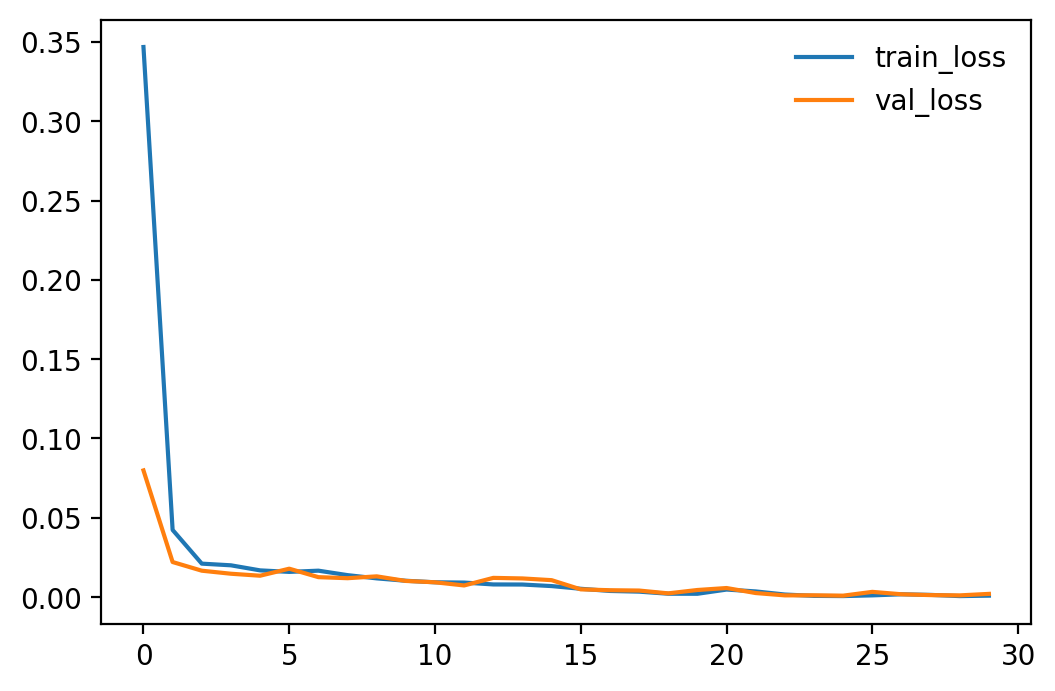

In [9]:
history=model.fit(train_data,train_label,epochs=30,batch_size=8,verbose=1,validation_data=(val_data,val_label))
fig,ax=plt.subplots()
ax.plot(history.history['loss'], label='train_loss')
ax.plot(history.history['val_loss'], label='val_loss')
ax.set_title = 'Loss of the model'
ax.set_xlabel = 'Time (Epochs)'
ax.set_ylabel = 'Loss'
ax.legend()

# Task 2: 
 How stable is your network to variations in initial conditions? Make a plot to show the network prediction in comparison to the solution from solve_ivp

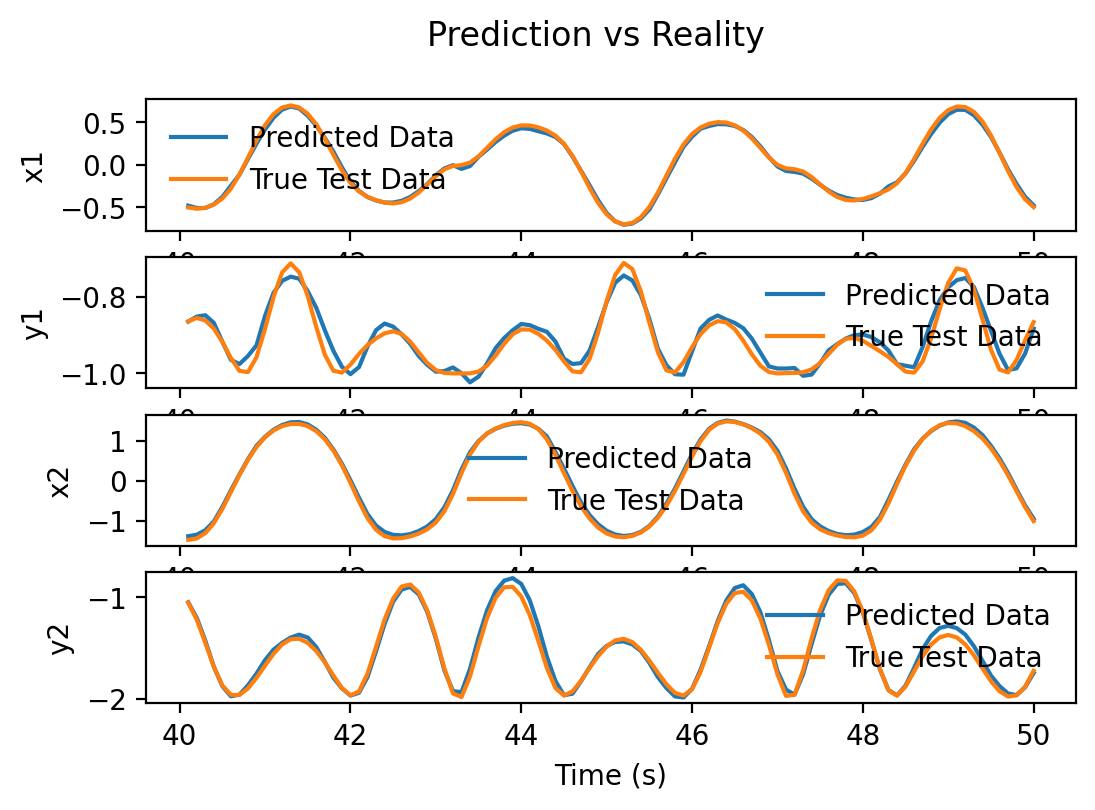

In [10]:
#Here we will plot the vanilla data
def plotPredVsReal(test_predict,test_label,title,test_data=None,num_vars=4):
    #print(test_data[0],test_predict[0],test_label[0])
    fig,ax=plt.subplots(num_vars,1)
    labels=["x1","y1","x2","y2"]
    fig.suptitle(title)
    for i in range(num_vars):
        ax[i].plot(t[-100:],test_predict[:,i],label="Predicted Data")
        ax[i].plot(t[-100:],test_label[:,i],label="True Test Data")
        if test_data is not None:
            ax[i].plot(t[-100-offset:0-offset],test_data[:,-1,i],label="Input Data")
        ax[i].set_xlabel("Time (s)")
        vari=i
        if num_vars==2:
            vari+=2
        ax[i].set_ylabel(labels[vari])
        ax[i].legend()

test_predict=model.predict(test_data)
plotPredVsReal(test_predict,test_label,"Prediction vs Reality")

### Vary initial conditions



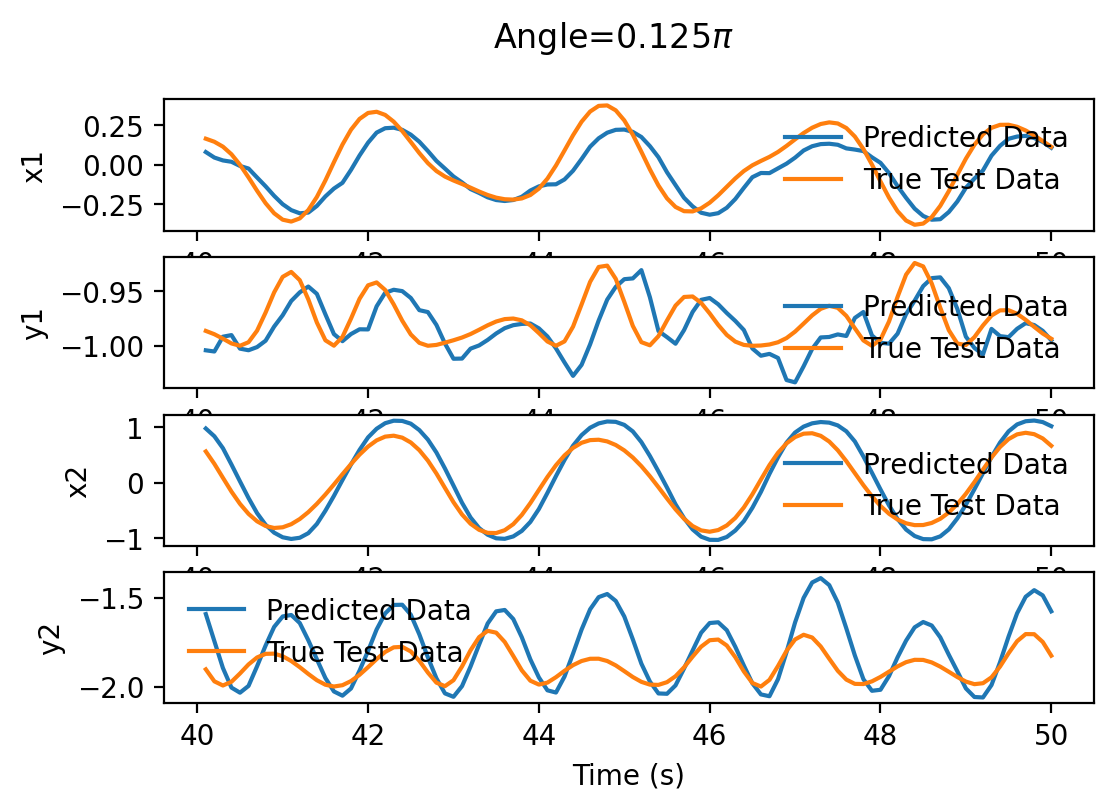

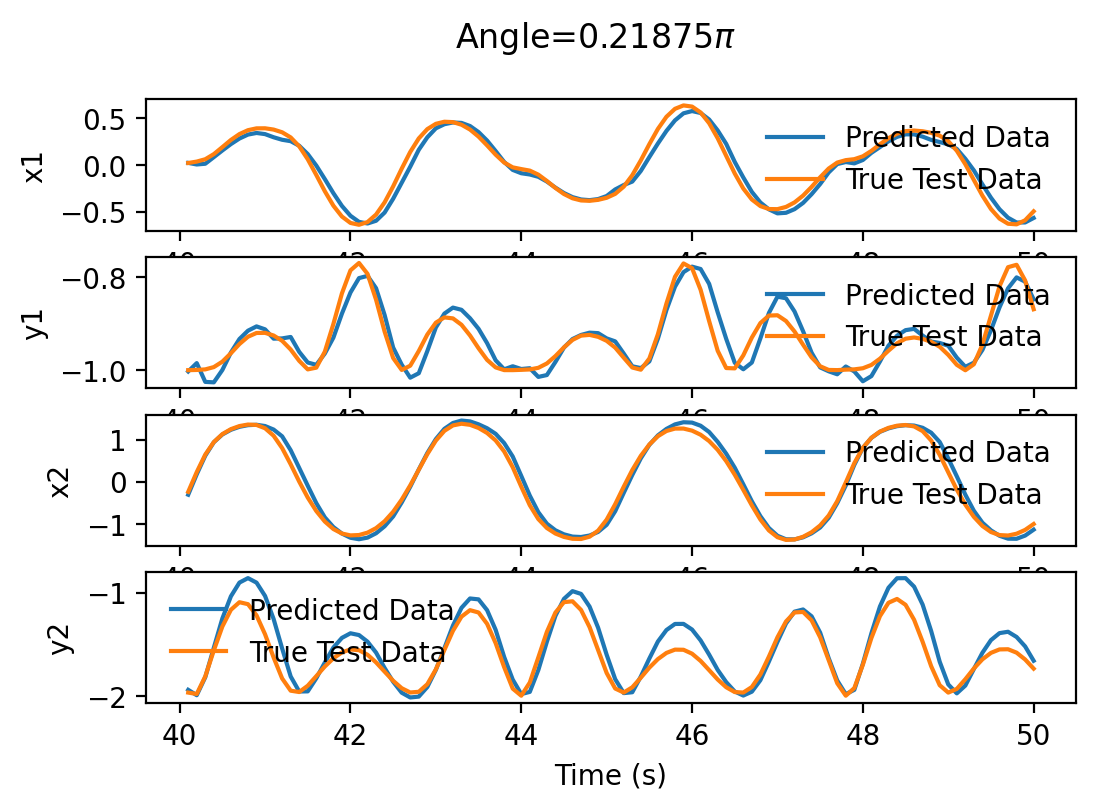

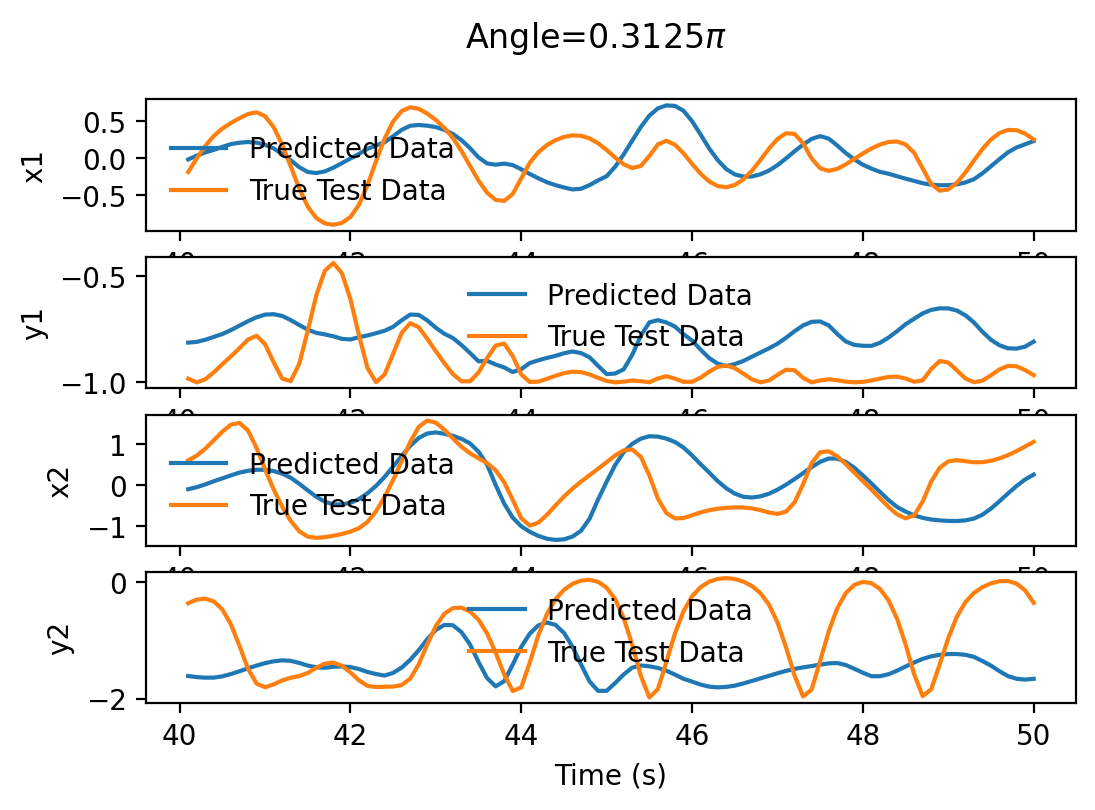

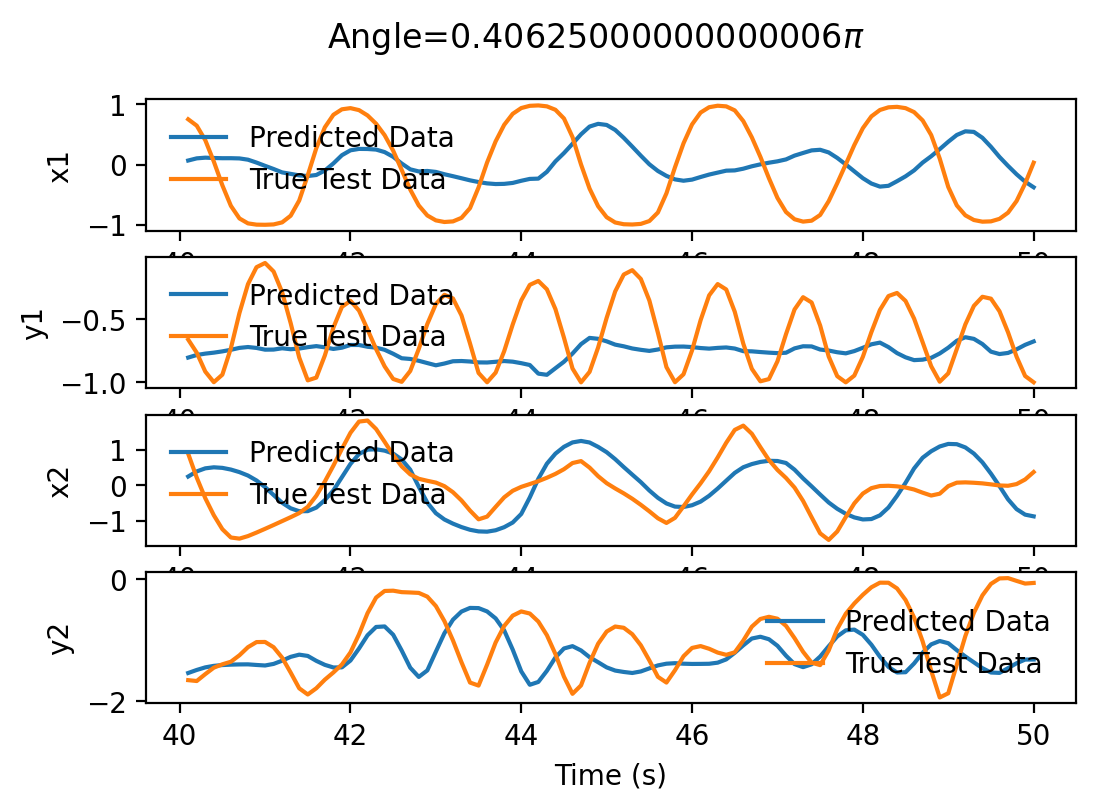

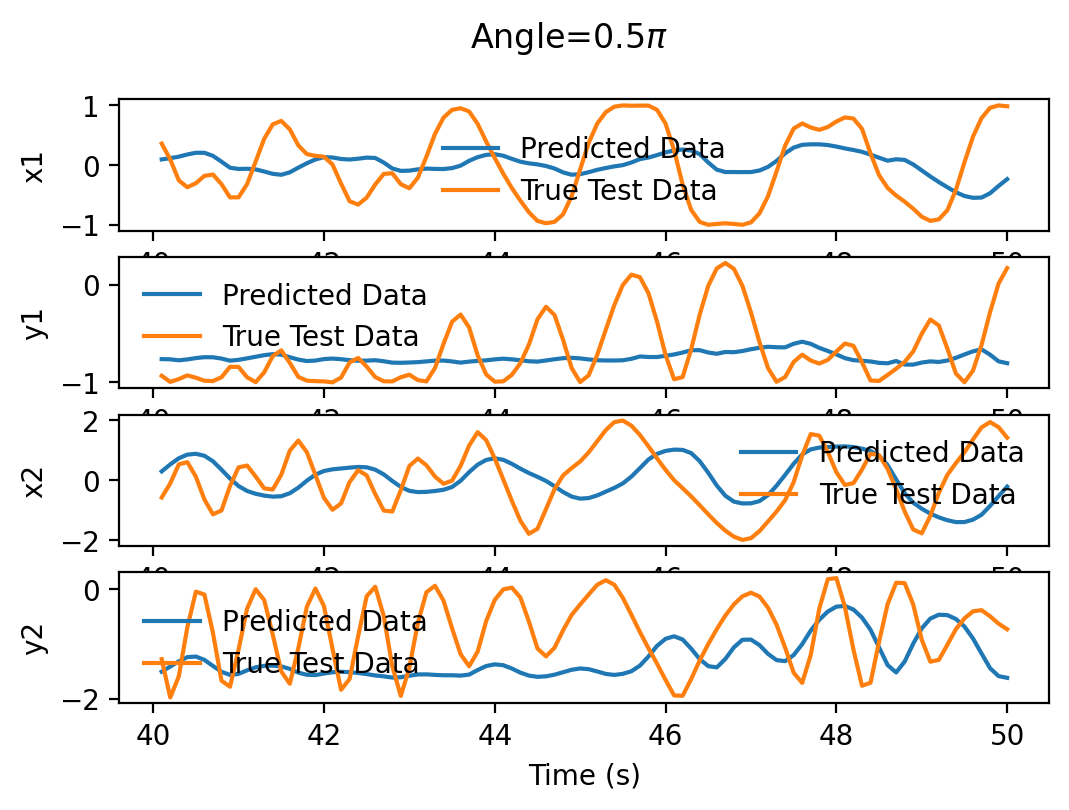

In [11]:
angles=np.linspace(np.pi/8,np.pi/2,5)
Nang=len(angles)

for ia in range(Nang):
    z0=[angles[ia],0,angles[ia],0]
    t,x1,y1,x2,y2=getTXY(z0,tmax,dt)
    data=np.vstack([x1,y1,x2,y2]).T
    train_data,val_data,test_data,train_label,val_label,test_label=getTestTrainVal(data,windowsize,offset)
    test_predict=model.predict(test_data)
    plotPredVsReal(test_predict,test_label,"Angle="+str(angles[ia]/np.pi)+"$\pi$")

In [12]:
def getMSE(test_predict,test_label):
    diff=(test_predict[:,:]-test_label[:,:])
    val=np.mean(diff**2)
    return val
def getMSENorm(test_predict,test_label):
    maxVal=np.max(test_label)
    diff=(test_predict[:,:]-test_label[:,:])/maxVal
    val=np.mean(diff**2)
    return val
getMSENorm(test_predict,test_label)

0.17443642012356164

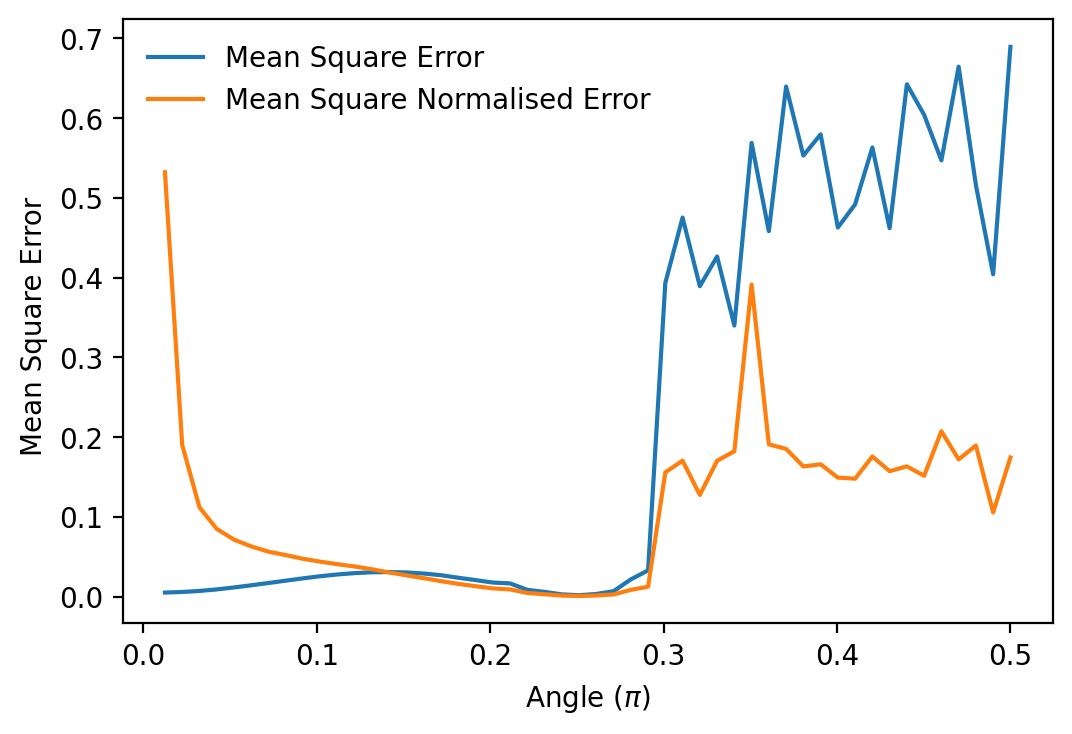

In [13]:
angles=np.linspace(np.pi/80,np.pi/2,50)
Nang=len(angles)
mse=np.zeros(Nang)
msen=np.zeros(Nang)
for ia in range(Nang):
    z0=[angles[ia],0,angles[ia],0]
    t,x1,y1,x2,y2=getTXY(z0,tmax,dt)
    data=np.vstack([x1,y1,x2,y2]).T
    train_data,val_data,test_data,train_label,val_label,test_label=getTestTrainVal(data,windowsize,offset)
    test_predict=model.predict(test_data)
    mse[ia]=getMSE(test_predict,test_label)
    msen[ia]=getMSENorm(test_predict,test_label)
fig,ax=plt.subplots()
ax.plot(angles/np.pi,mse,label="Mean Square Error")
ax.plot(angles/np.pi,msen,label="Mean Square Normalised Error")
ax.set_xlabel ('Angle ($\pi$)')
ax.set_ylabel ('Mean Square Error ')
ax.legend()


#### Discussion
This is really the plot I was looking for, but the question wasn't quite clearly stated. But here you see that a network trained with a starting angle $\pi/4$ can do reasonably well at predicting the values for all angles below the point where things get chaotic. Or at least that is what the MSE graph seems to show (and it is certainly true that above $0.3\pi$ the cahos takes over) but at the low starting angles the normalised graph diverges.

You could also have made a plot in terms of angles which might have showed the same thing.

# Task 3:
How far into the future can a network predict? Make a plot showing how the deviation between predicted position and actual position (from solve_ivp above) vary as a function of extrapolation time from $t=t_0 + 20 \delta t$ to $t=t_0 + 100 \delta t$  (e.g. for each extrapolation time, train a new version of the network and then plot the performance)

In [14]:
offsets=np.arange(20,101,10)
Noff=len(offsets)
print(offsets)
mse=np.zeros(Noff)
msen=np.zeros(Noff)

z0=[np.pi/4,0,np.pi/4,0]
tmax, dt = 100, 0.1
t,x1,y1,x2,y2=getTXY(z0,tmax,dt)
data=np.vstack([x1,y1,x2,y2]).T
print(data.shape)

windowsize=50 #Number of samples we will use to train our network

for ioff in tqdm(range(Noff)):
    offset=offsets[ioff] #How many samples into the future to predict
    train_data,val_data,test_data,train_label,val_label,test_label=getTestTrainVal(data,windowsize,offset)
    model=create_model()
    history=model.fit(train_data,train_label,epochs=30,batch_size=8,verbose=0,validation_data=(val_data,val_label))
    test_predict=model.predict(test_data)
    mse[ioff]=getMSE(test_predict,test_label)
    msen[ioff]=getMSENorm(test_predict,test_label)



  0%|          | 0/9 [00:00<?, ?it/s]

[ 20  30  40  50  60  70  80  90 100]
(1001, 4)


100%|██████████| 9/9 [09:45<00:00, 65.08s/it]


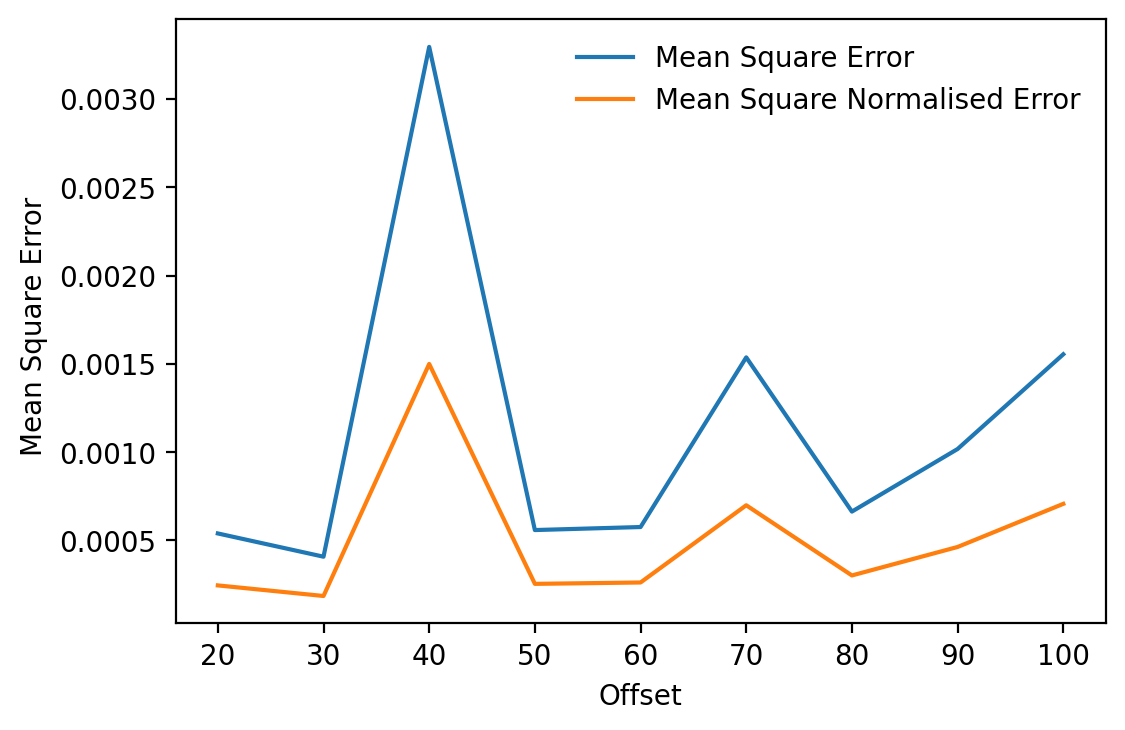

In [15]:

fig,ax=plt.subplots()
ax.plot(offsets,mse[0:9],label="Mean Square Error")
ax.plot(offsets,msen[0:9],label="Mean Square Normalised Error")
ax.set_xlabel ('Offset')
ax.set_ylabel ('Mean Square Error ')
ax.legend()

#### Discussion
So at least for the starting angle of $\pi/4$  the network is able to make predictions far into the future.

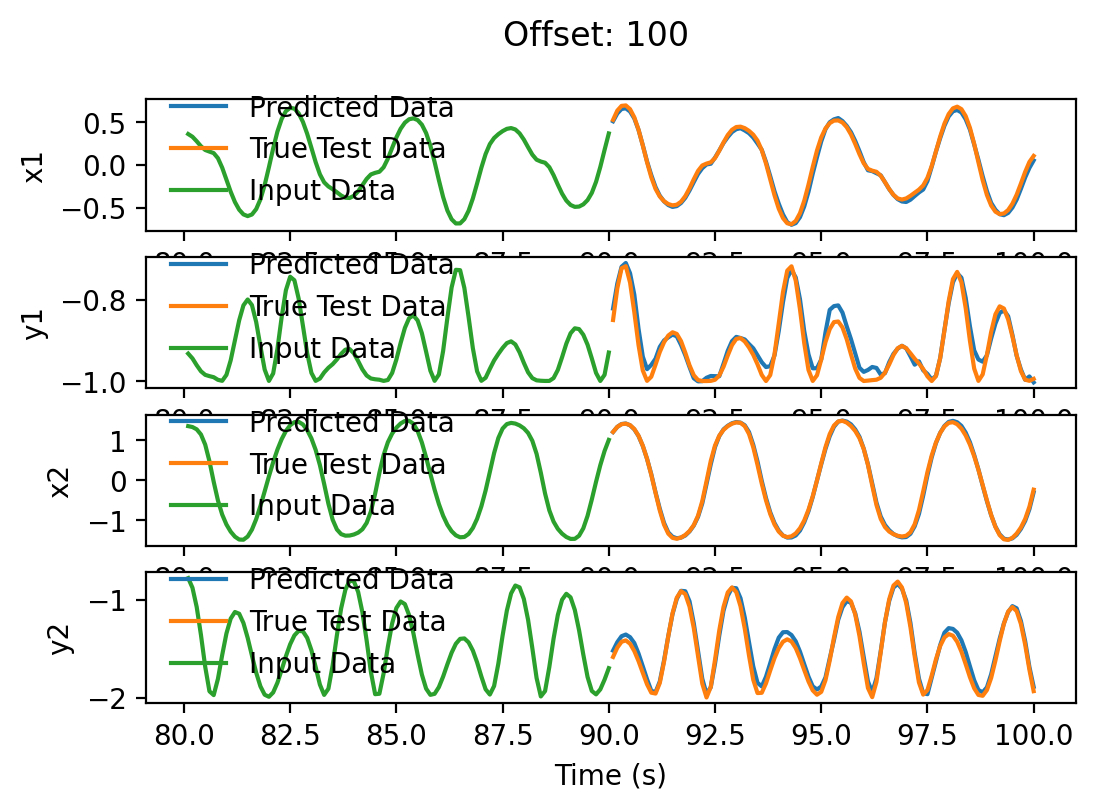

In [16]:
plotPredVsReal(test_predict,test_label,title="Offset: "+str(offset),test_data=test_data)
#This plot is trying to illustrate the Offset:100 performance.

# Task 4: 
Repeat steps 1-3 for the initial conditions $z_0=[\pi/2,0,\pi/2,0]$ which give a much more complex path.


Epoch 1/100
78/78 [==============================] - 3s 32ms/step - loss: 0.4571 - val_loss: 0.3949
Epoch 2/100
78/78 [==============================] - 2s 27ms/step - loss: 0.3810 - val_loss: 0.3701
Epoch 3/100
78/78 [==============================] - 2s 26ms/step - loss: 0.3665 - val_loss: 0.3672
Epoch 4/100
78/78 [==============================] - 2s 23ms/step - loss: 0.3414 - val_loss: 0.3076
Epoch 5/100
78/78 [==============================] - 2s 22ms/step - loss: 0.3225 - val_loss: 0.3203
Epoch 6/100
78/78 [==============================] - 2s 25ms/step - loss: 0.3016 - val_loss: 0.2790
Epoch 7/100
78/78 [==============================] - 2s 23ms/step - loss: 0.2891 - val_loss: 0.2939
Epoch 8/100
78/78 [==============================] - 2s 23ms/step - loss: 0.2674 - val_loss: 0.3097
Epoch 9/100
78/78 [==============================] - 2s 24ms/step - loss: 0.2379 - val_loss: 0.2634
Epoch 10/100
78/78 [==============================] - 2s 28ms/step - loss: 0.2213 - val_loss: 0.2252

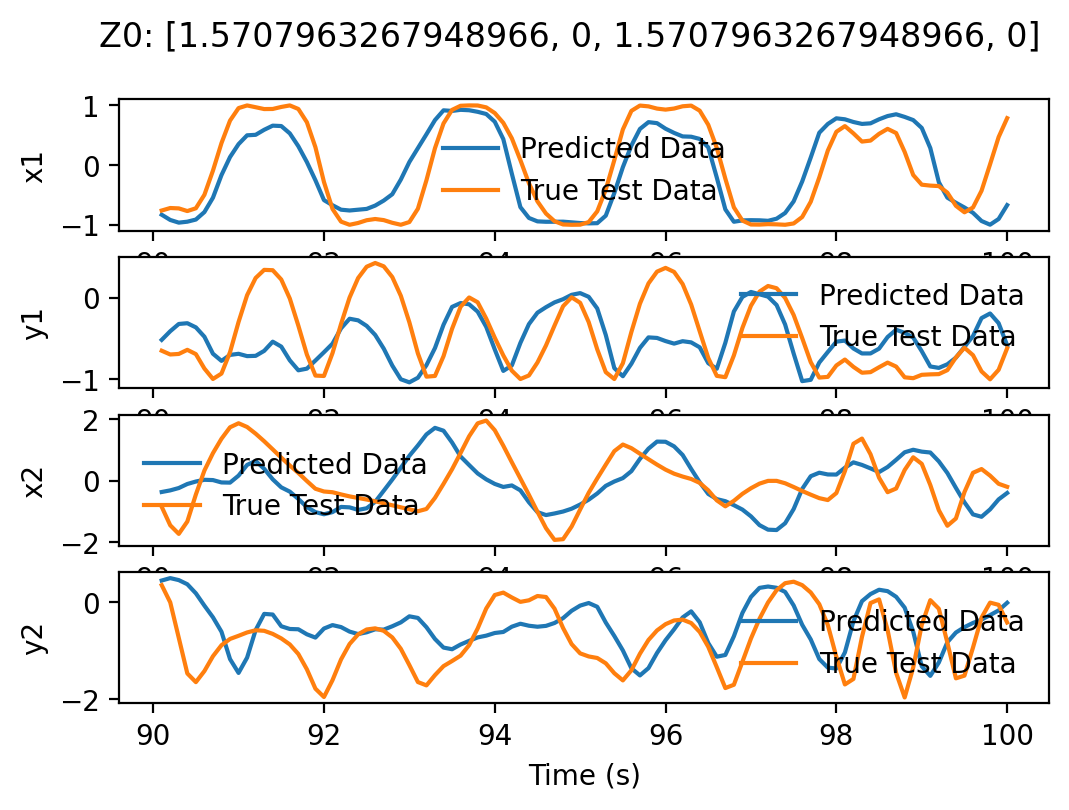

In [17]:
z0=[np.pi/2,0,np.pi/2,0]
tmax, dt = 100, 0.1
t,x1,y1,x2,y2=getTXY(z0,tmax,dt)
data=np.vstack([x1,y1,x2,y2]).T

offset=20
windowsize=50 #Number of samples we will use to train our network
train_data,val_data,test_data,train_label,val_label,test_label=getTestTrainVal(data,windowsize,offset)
model=create_model()
history=model.fit(train_data,train_label,epochs=100,batch_size=8,verbose=1,validation_data=(val_data,val_label))
test_predict=model.predict(test_data)
plotPredVsReal(test_predict,test_label,title="Z0: "+str(z0))

100%|██████████| 8/8 [00:04<00:00,  1.65it/s]


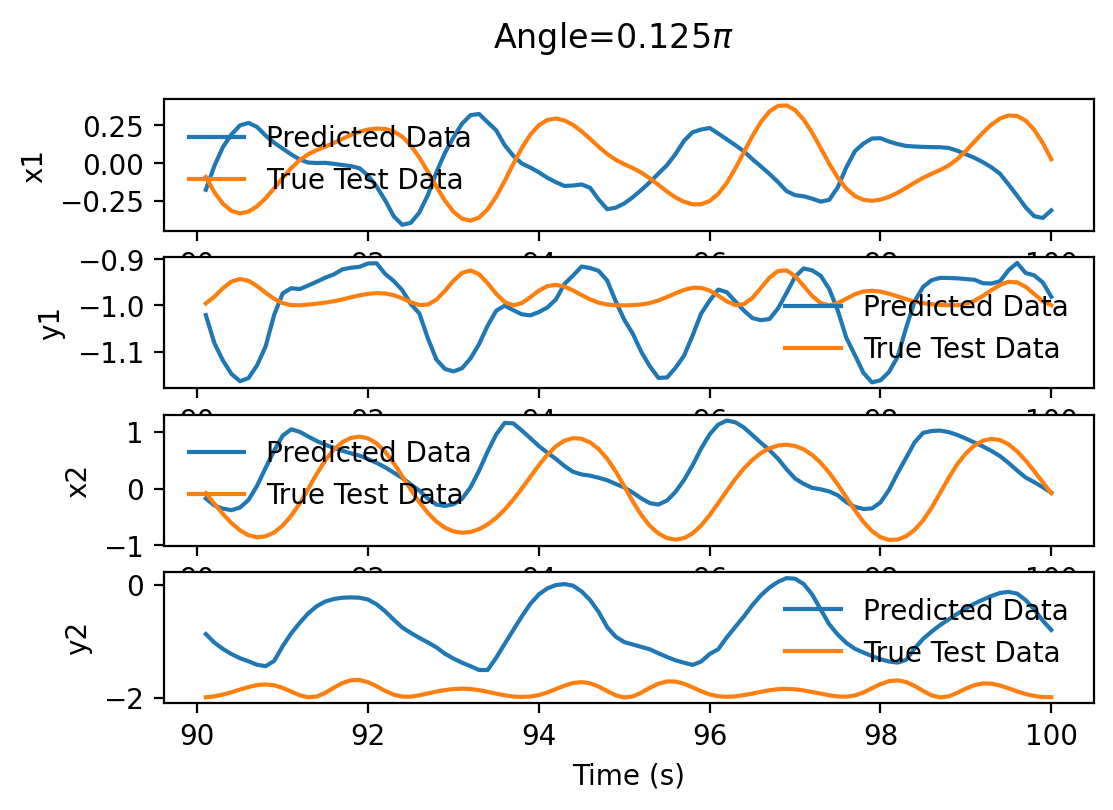

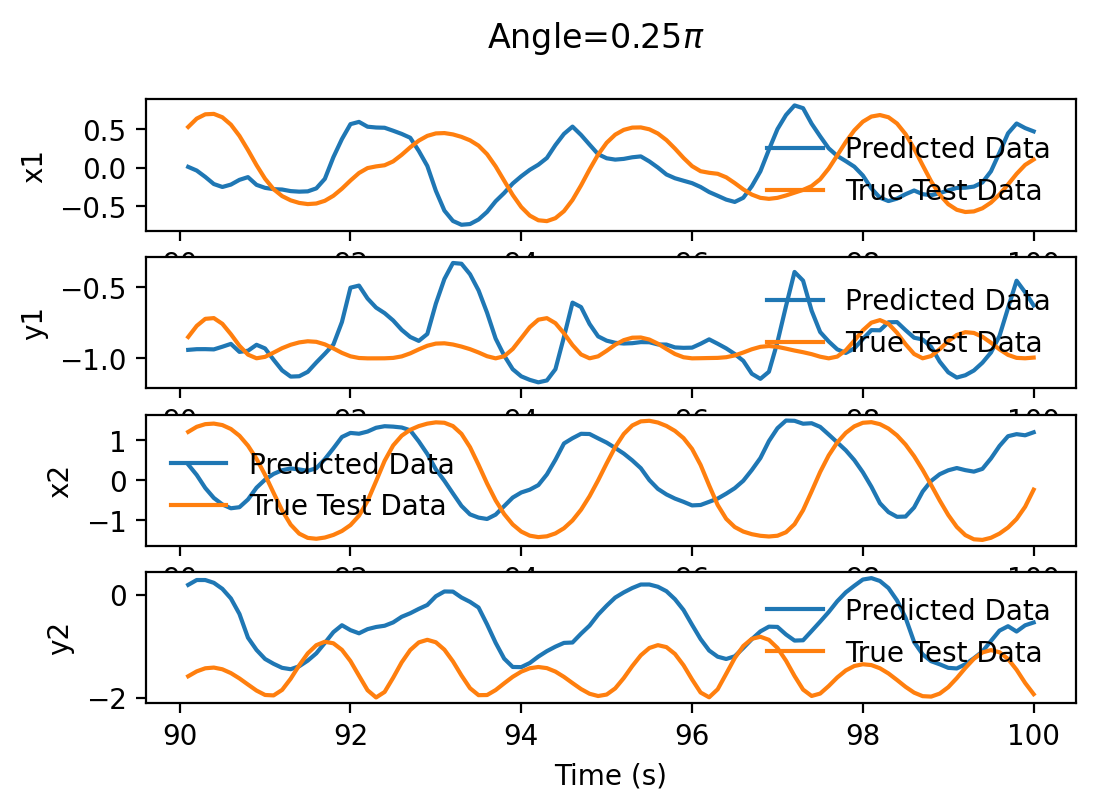

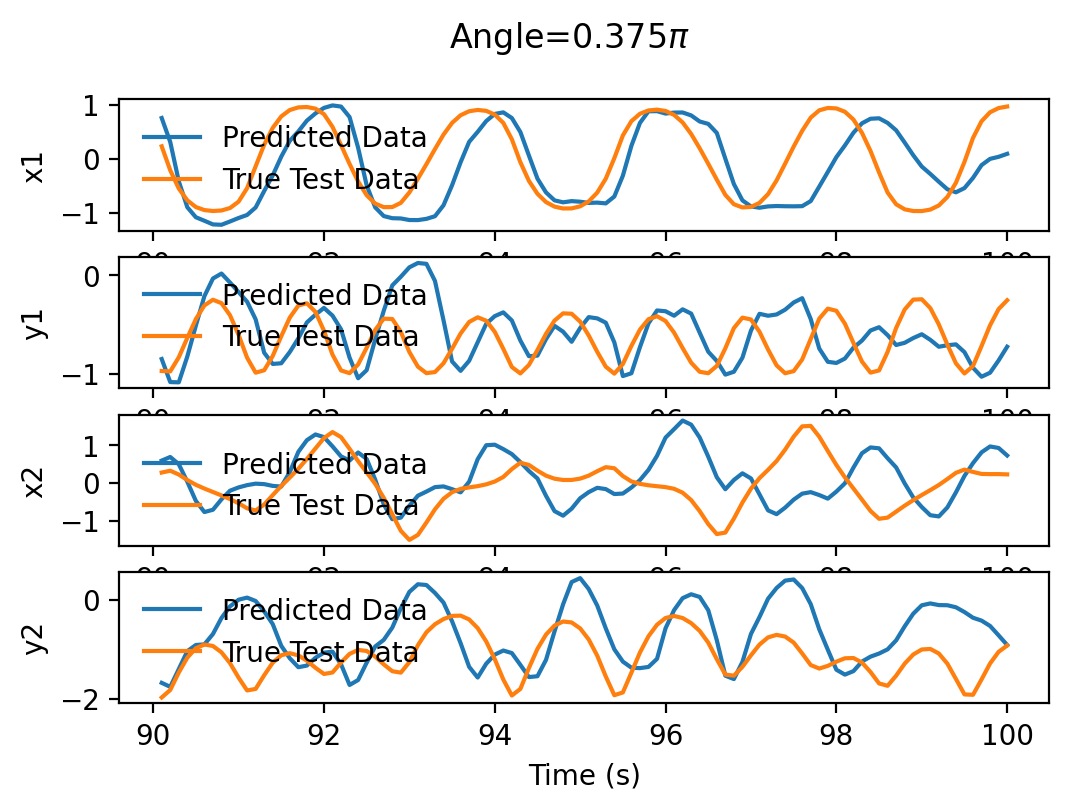

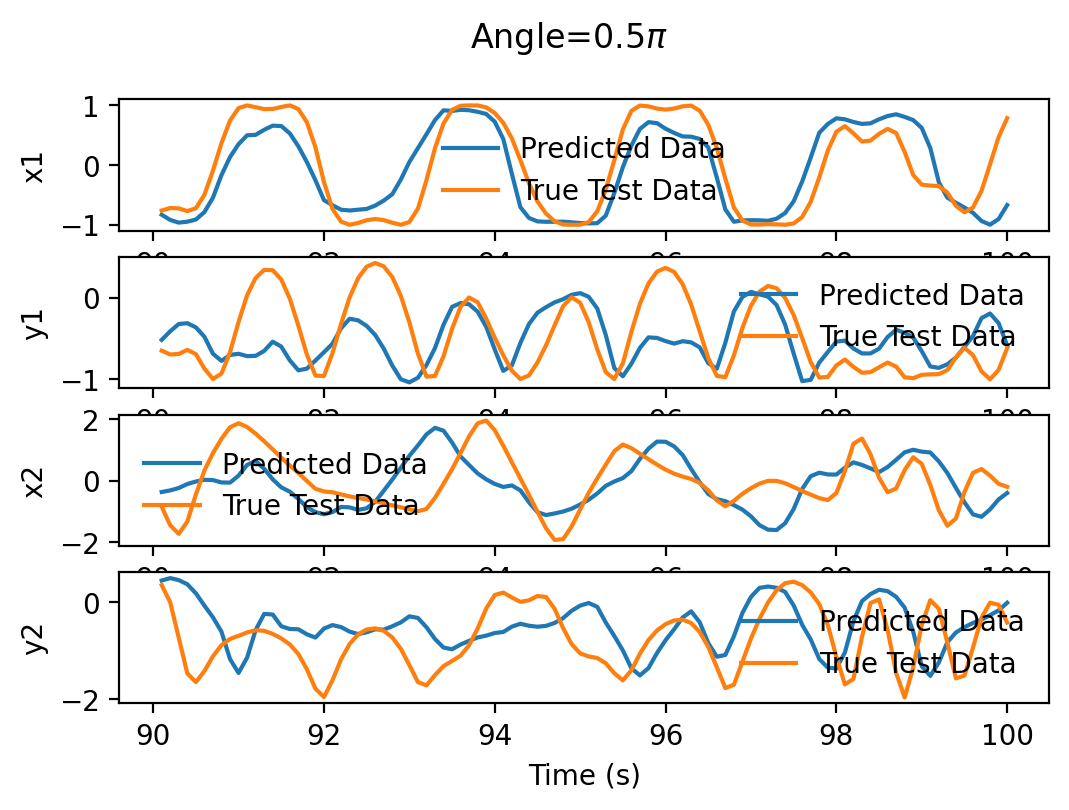

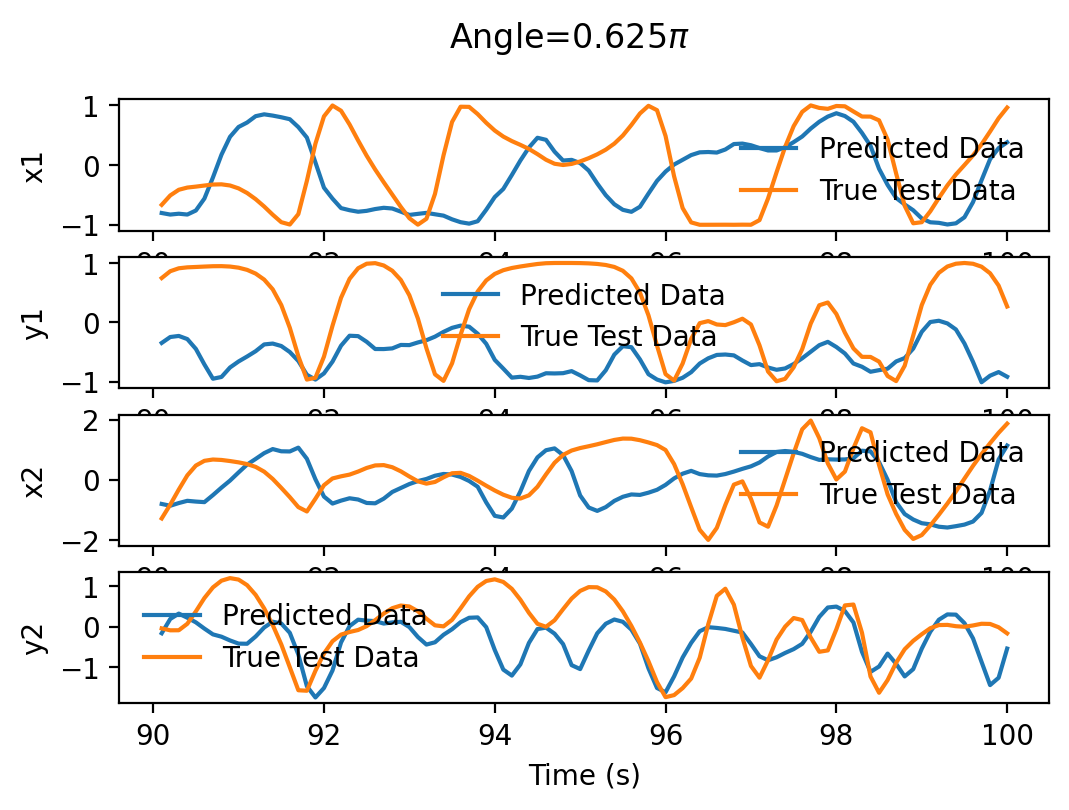

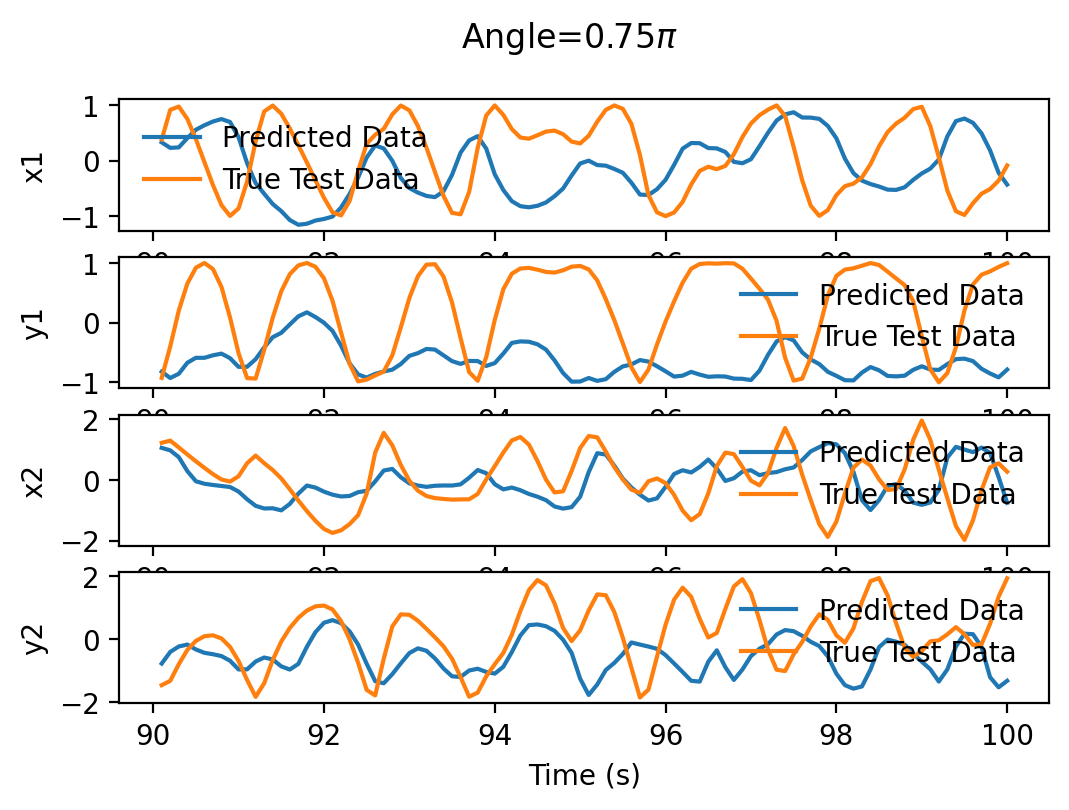

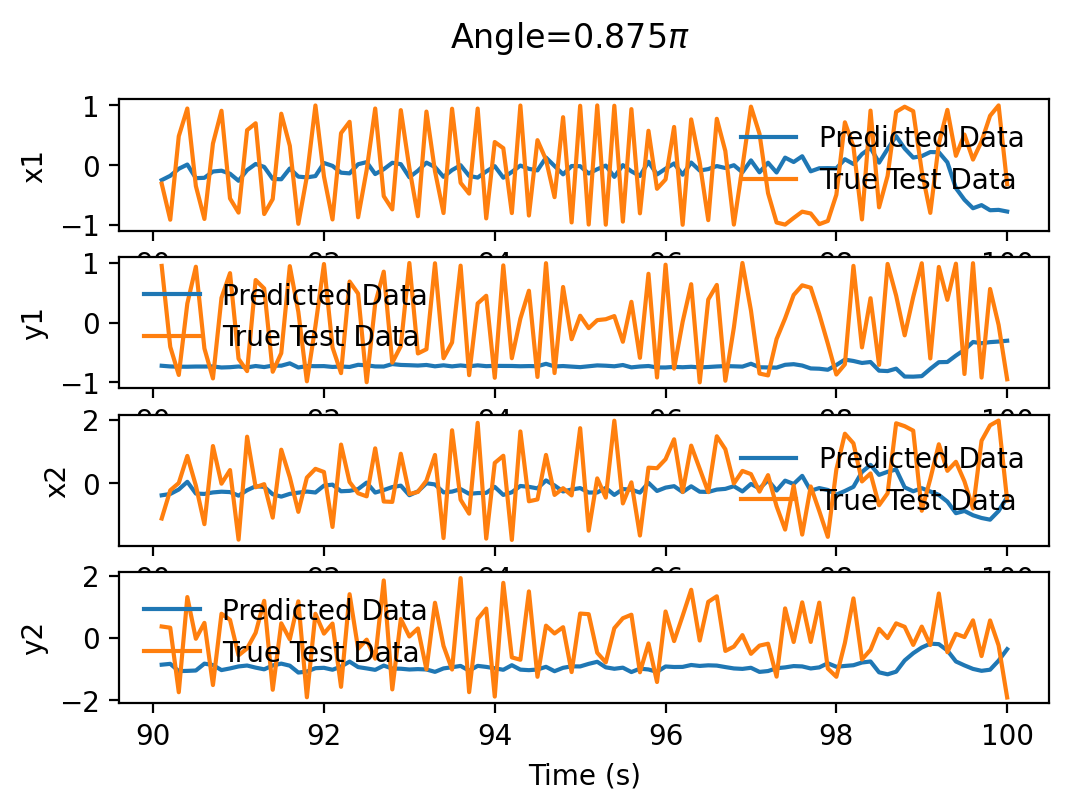

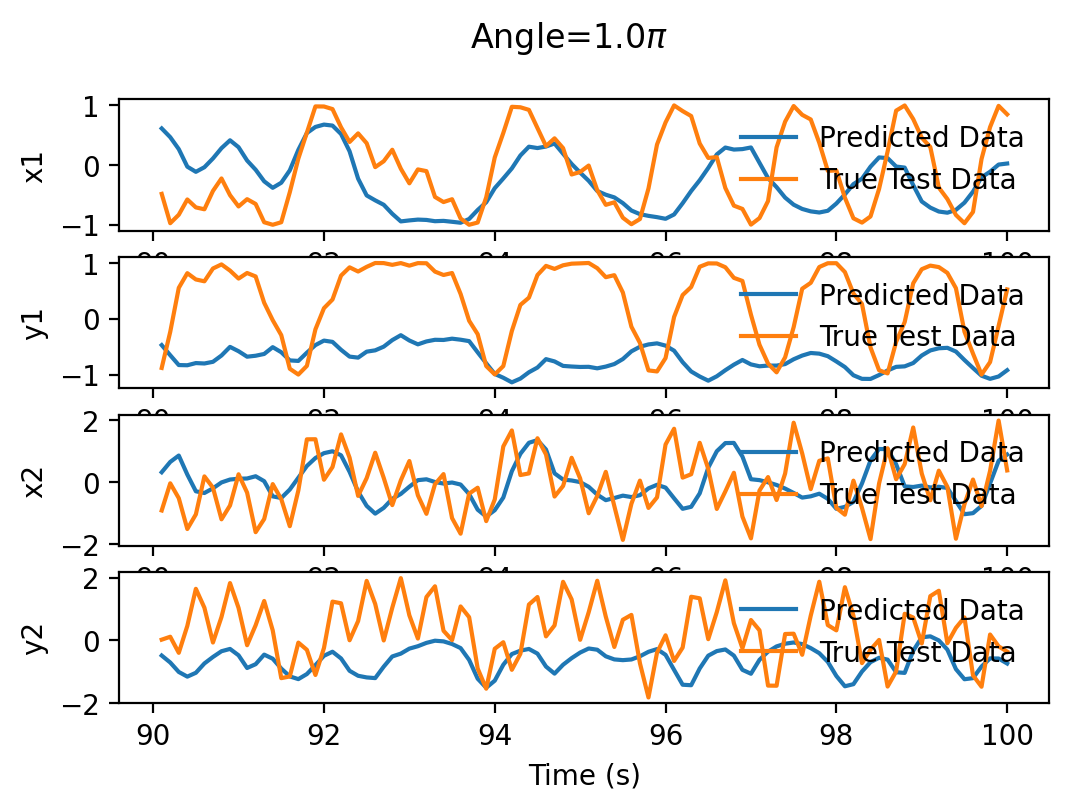

In [18]:
angles=np.linspace(np.pi/8,np.pi,8)
Nang=len(angles)

for ia in tqdm(range(Nang)):
    z0=[angles[ia],0,angles[ia],0]
    t,x1,y1,x2,y2=getTXY(z0,tmax,dt)
    data=np.vstack([x1,y1,x2,y2]).T
    train_data,val_data,test_data,train_label,val_label,test_label=getTestTrainVal(data,windowsize,offset)
    test_predict=model.predict(test_data)
    plotPredVsReal(test_predict,test_label,"Angle="+str(angles[ia]/np.pi)+"$\pi$")

100%|██████████| 50/50 [00:46<00:00,  1.07it/s]


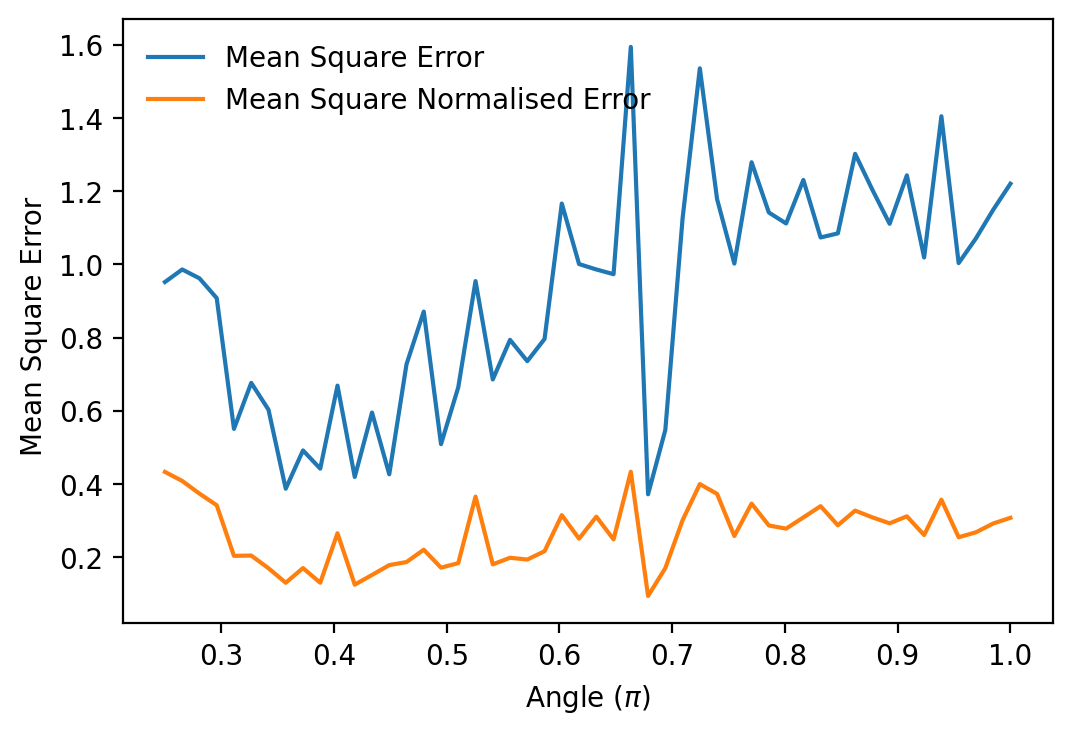

In [19]:
angles=np.linspace(np.pi/4,np.pi,50)
Nang=len(angles)
mse=np.zeros(Nang)
msen=np.zeros(Nang)
for ia in tqdm(range(Nang)):
    z0=[angles[ia],0,angles[ia],0]
    t,x1,y1,x2,y2=getTXY(z0,tmax,dt)
    data=np.vstack([x1,y1,x2,y2]).T
    train_data,val_data,test_data,train_label,val_label,test_label=getTestTrainVal(data,windowsize,offset)
    test_predict=model.predict(test_data)
    mse[ia]=getMSE(test_predict,test_label)
    msen[ia]=getMSENorm(test_predict,test_label)
fig,ax=plt.subplots()
ax.plot(angles/np.pi,mse,label="Mean Square Error")
ax.plot(angles/np.pi,msen,label="Mean Square Normalised Error")
ax.set_xlabel ('Angle ($\pi$)')
ax.set_ylabel ('Mean Square Error ')
ax.legend()



#### Discussion
It is really hard to predict the chaotic motion!  If we pick a smaller dt the netork can work well but then it is only prediciting very short term trends. 

In [20]:
offsets=np.arange(1,101,10)
Noff=len(offsets)
print(offsets)
mse=np.zeros(Noff)
msen=np.zeros(Noff)

z0=[np.pi/2,0,np.pi/2,0]
tmax, dt = 100, 0.1
t,x1,y1,x2,y2=getTXY(z0,tmax,dt)
data=np.vstack([x1,y1,x2,y2]).T
print(data.shape)

windowsize=50 #Number of samples we will use to train our network

for ioff in tqdm(range(Noff)):
    offset=offsets[ioff] #How many samples into the future to predict
    train_data,val_data,test_data,train_label,val_label,test_label=getTestTrainVal(data,windowsize,offset)
    model=create_model()
    history=model.fit(train_data,train_label,epochs=30,batch_size=8,verbose=0,validation_data=(val_data,val_label))
    test_predict=model.predict(test_data)
    mse[ioff]=getMSE(test_predict,test_label)
    msen[ioff]=getMSENorm(test_predict,test_label)

  0%|          | 0/10 [00:00<?, ?it/s]

[ 1 11 21 31 41 51 61 71 81 91]
(1001, 4)


100%|██████████| 10/10 [11:45<00:00, 70.54s/it]


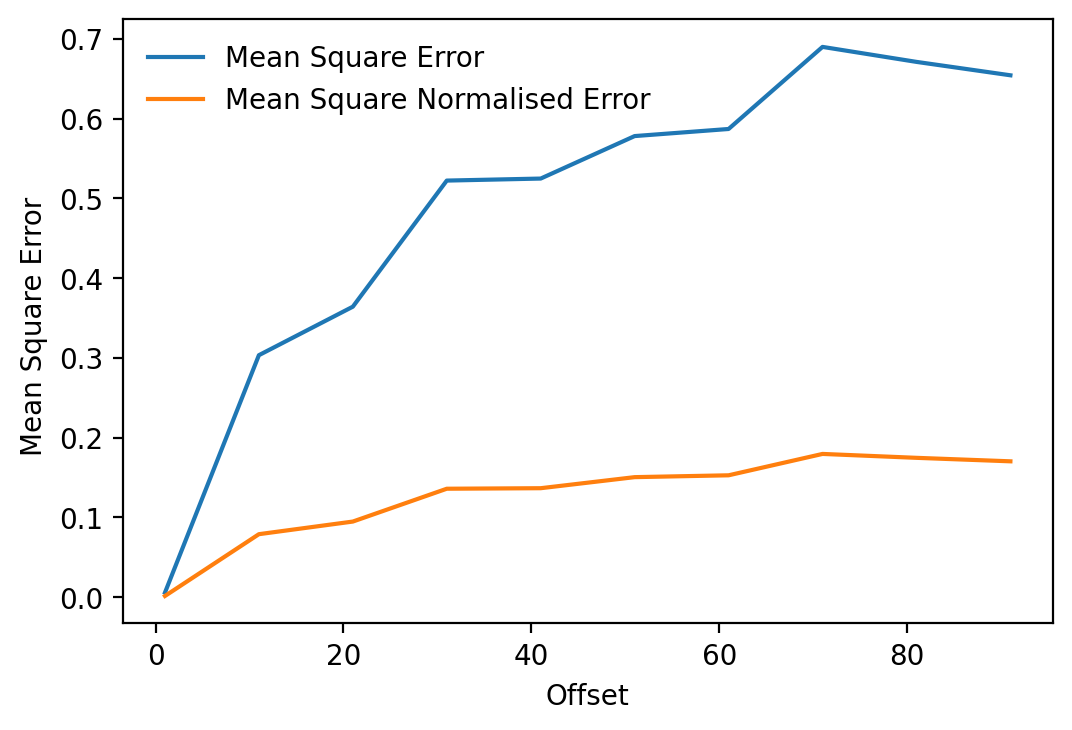

In [21]:

fig,ax=plt.subplots()
ax.plot(offsets,mse,label="Mean Square Error")
ax.plot(offsets,msen,label="Mean Square Normalised Error")
ax.set_xlabel ('Offset')
ax.set_ylabel ('Mean Square Error ')
ax.legend()

#### Discussion
Here you see the behaviour you might naively expect in that the error increase as we move from predicting small offsets to large offsets.

# Task 5
Repeat steps 1-4 but only train your neural network on the cartesian coordinates of the mass $m_2$ (i.e without showing your neural network the positions of the mass $m_1$)

## $z0=[\pi/4,0,\pi/4,0]$

Epoch 1/30
78/78 [==============================] - 2s 29ms/step - loss: 0.2709 - val_loss: 0.0372
Epoch 2/30
78/78 [==============================] - 2s 25ms/step - loss: 0.0321 - val_loss: 0.0254
Epoch 3/30
78/78 [==============================] - 2s 25ms/step - loss: 0.0255 - val_loss: 0.0181
Epoch 4/30
78/78 [==============================] - 2s 24ms/step - loss: 0.0206 - val_loss: 0.0146
Epoch 5/30
78/78 [==============================] - 2s 27ms/step - loss: 0.0210 - val_loss: 0.0274
Epoch 6/30
78/78 [==============================] - 2s 26ms/step - loss: 0.0159 - val_loss: 0.0105
Epoch 7/30
78/78 [==============================] - 2s 27ms/step - loss: 0.0068 - val_loss: 0.0053
Epoch 8/30
78/78 [==============================] - 2s 27ms/step - loss: 0.0043 - val_loss: 0.0026
Epoch 9/30
78/78 [==============================] - 2s 26ms/step - loss: 0.0029 - val_loss: 0.0061
Epoch 10/30
78/78 [==============================] - 2s 24ms/step - loss: 0.0030 - val_loss: 0.0026
Epoch 11/

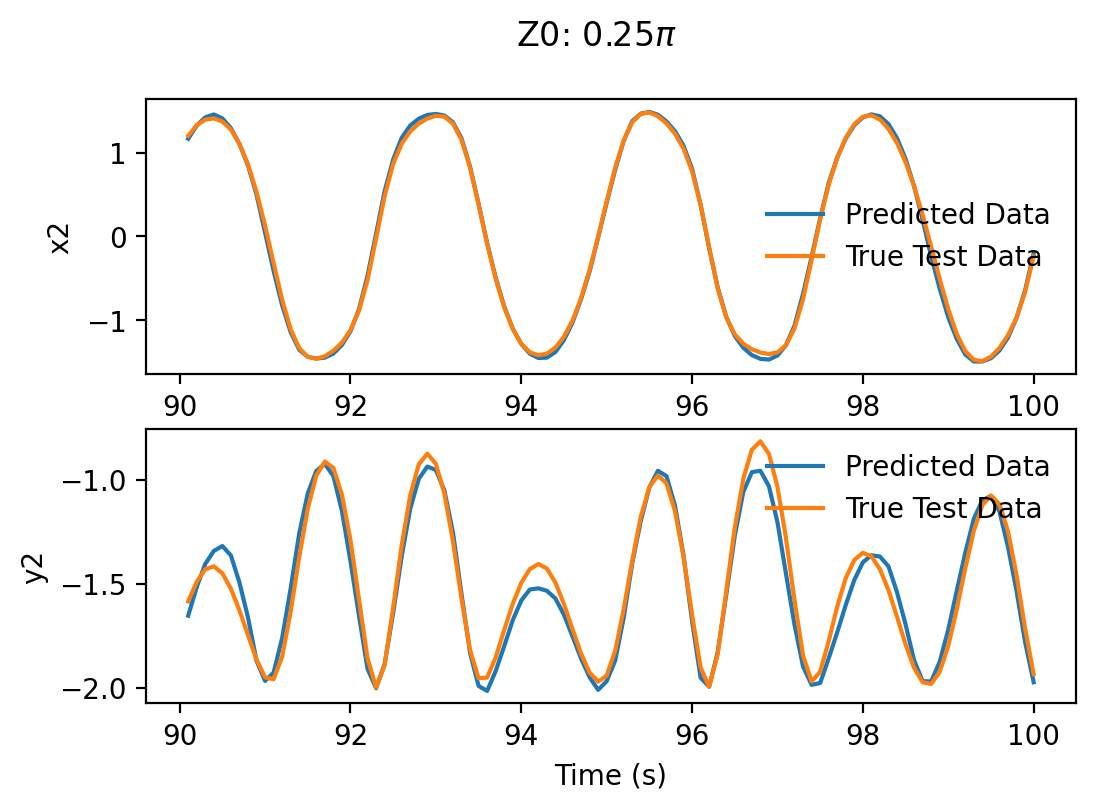

In [23]:
z0=[np.pi/4,0,np.pi/4,0]
tmax, dt = 100, 0.1
t,x1,y1,x2,y2=getTXY(z0,tmax,dt)
data=np.vstack([x2,y2]).T

offset=20
windowsize=50 #Number of samples we will use to train our network
train_data,val_data,test_data,train_label,val_label,test_label=getTestTrainVal(data,windowsize,offset)
model=create_model(2)
history=model.fit(train_data,train_label,epochs=30,batch_size=8,verbose=1,validation_data=(val_data,val_label))
test_predict=model.predict(test_data)
plotPredVsReal(test_predict,test_label,title="Z0: "+str(z0[0]/np.pi)+"$\pi$",num_vars=2)

100%|██████████| 8/8 [00:04<00:00,  1.81it/s]


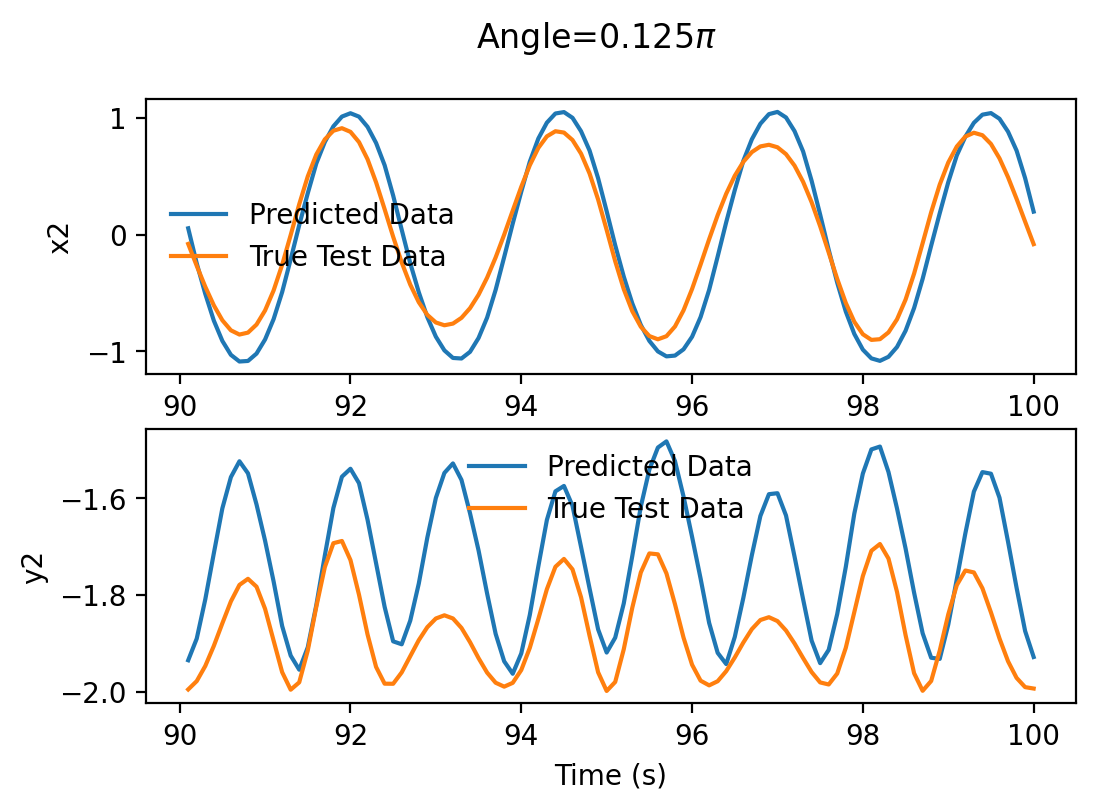

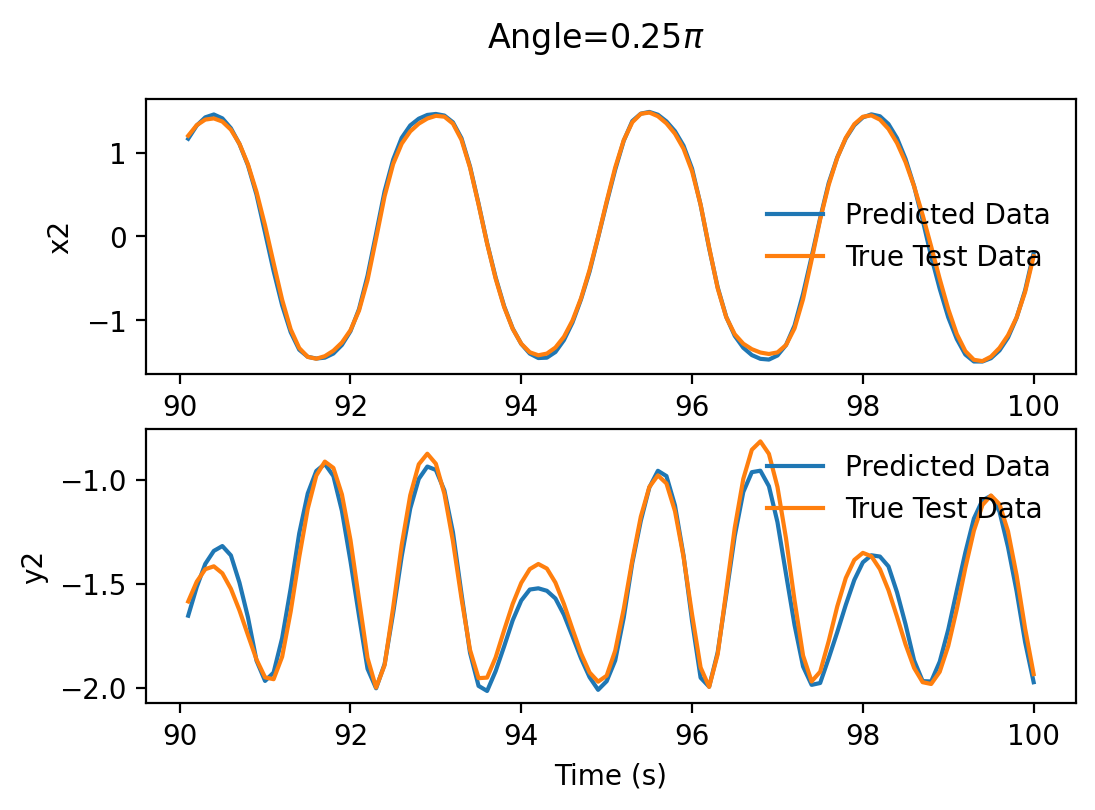

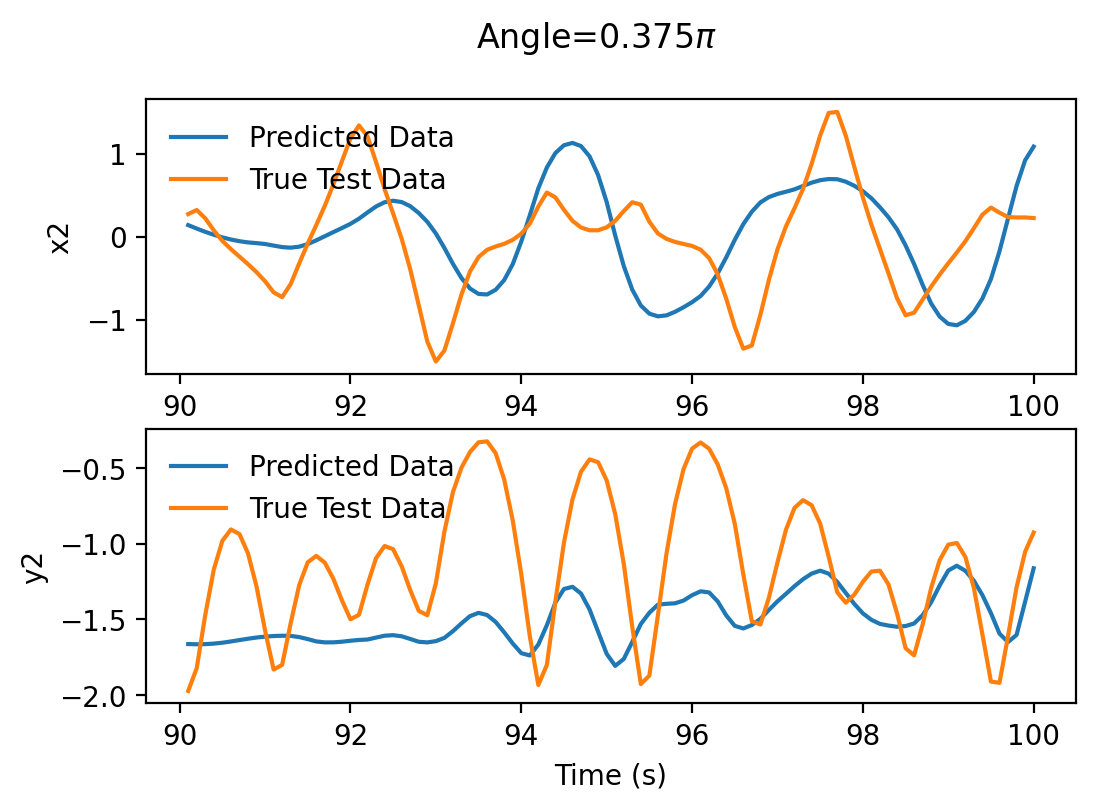

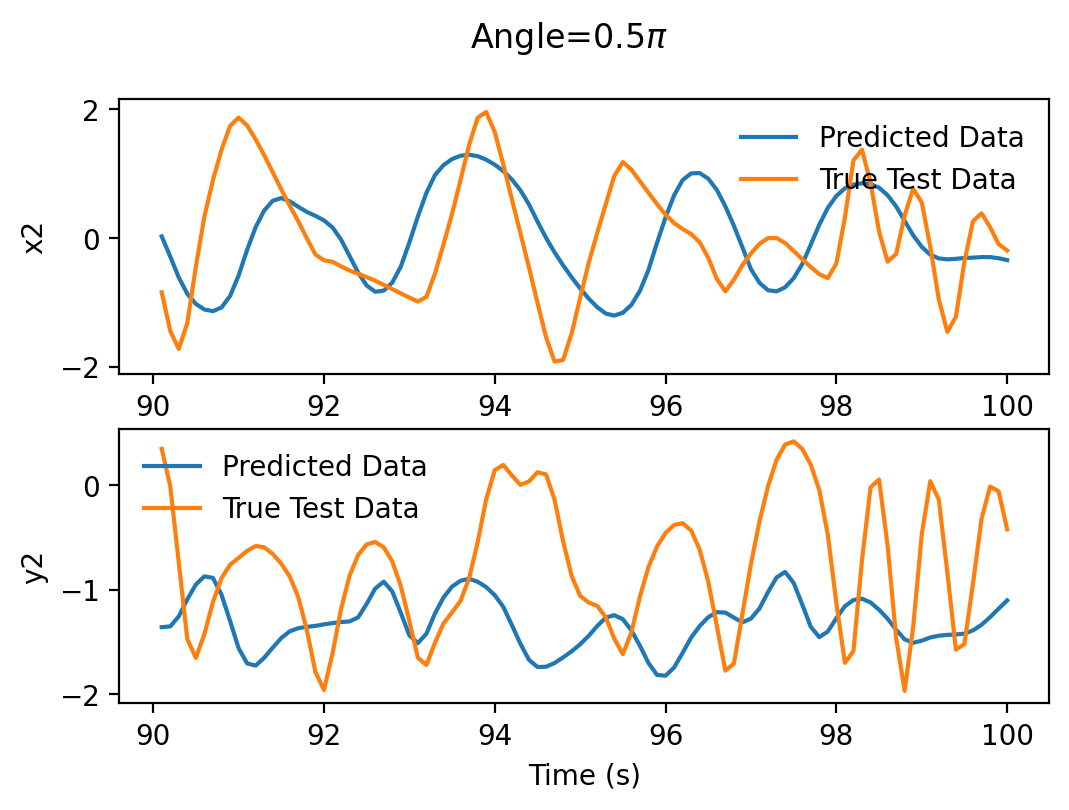

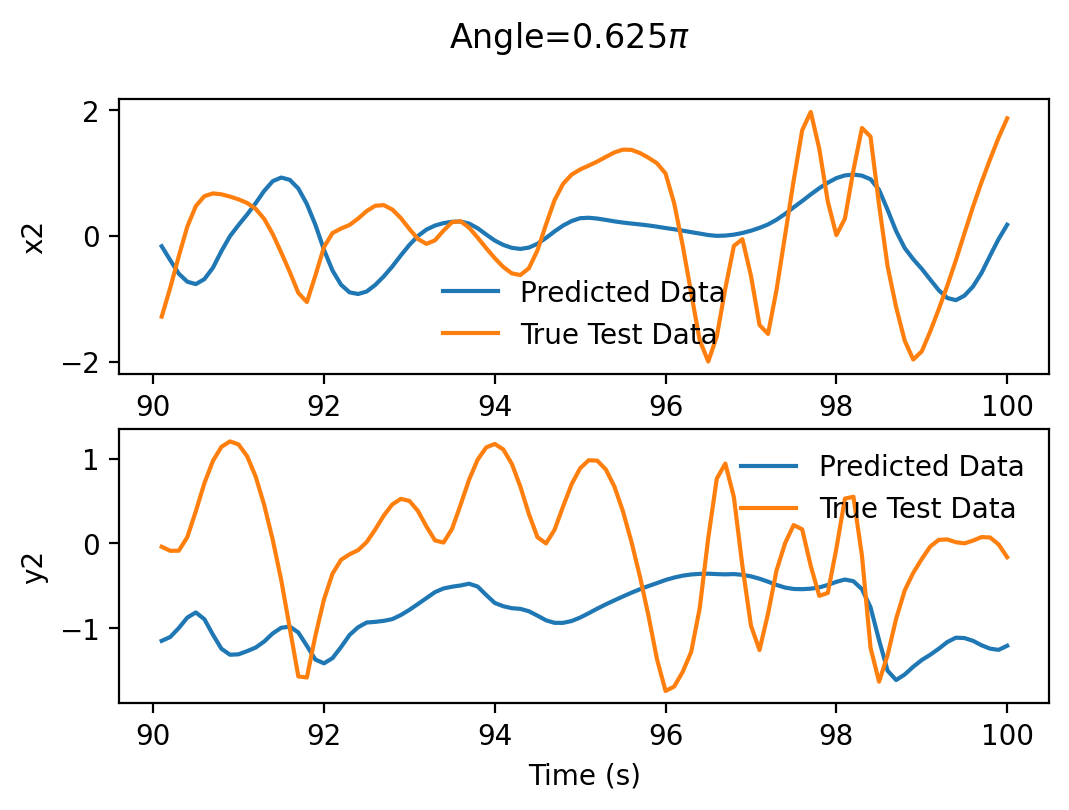

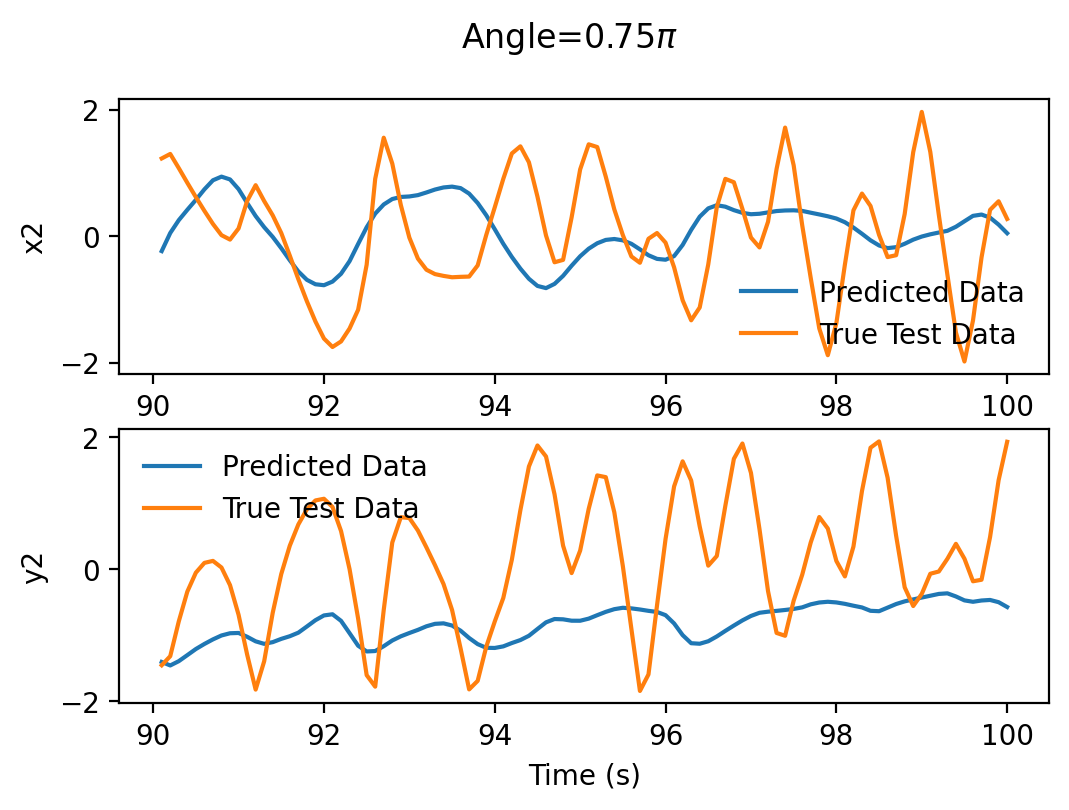

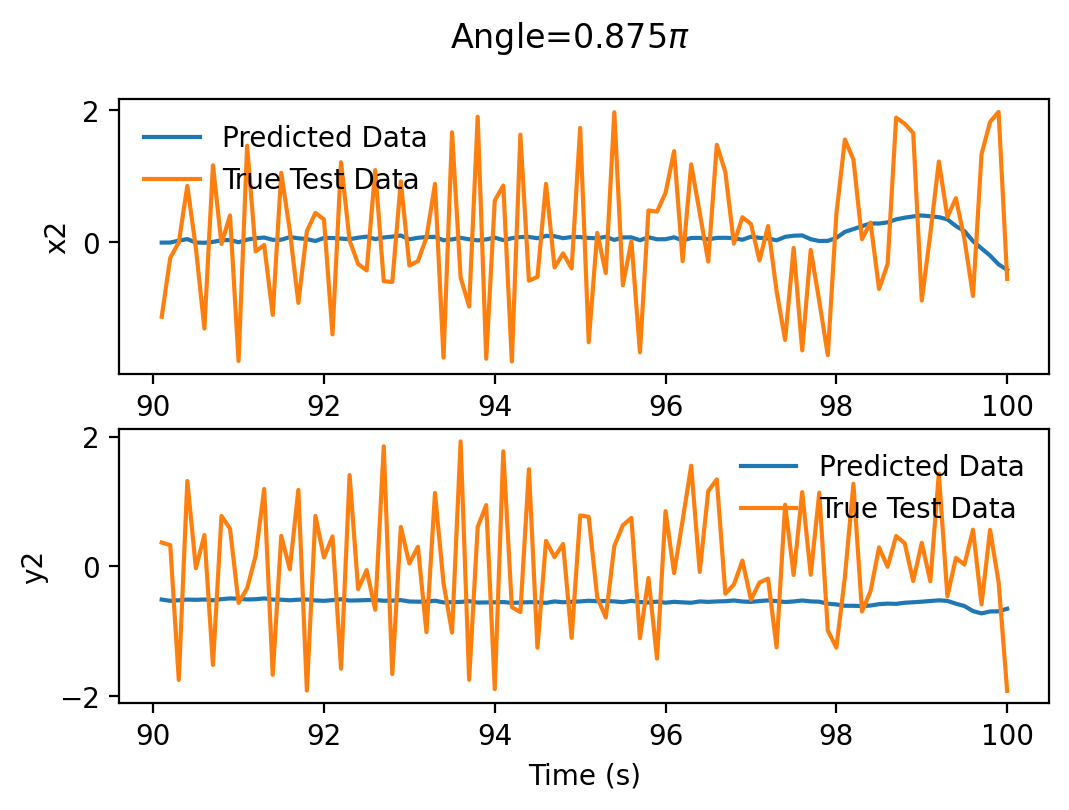

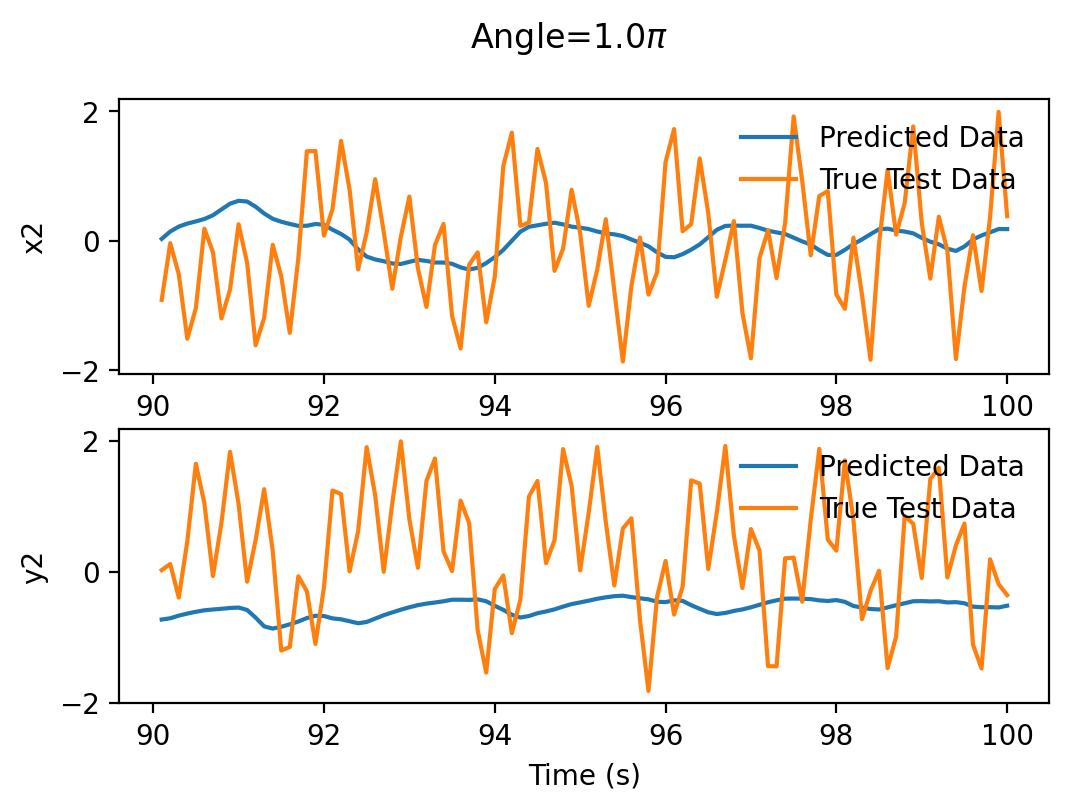

In [24]:
angles=np.linspace(np.pi/8,np.pi,8)
Nang=len(angles)

for ia in tqdm(range(Nang)):
    z0=[angles[ia],0,angles[ia],0]
    t,x1,y1,x2,y2=getTXY(z0,tmax,dt)
    data=np.vstack([x2,y2]).T
    train_data,val_data,test_data,train_label,val_label,test_label=getTestTrainVal(data,windowsize,offset)
    test_predict=model.predict(test_data)
    plotPredVsReal(test_predict,test_label,"Angle="+str(angles[ia]/np.pi)+"$\pi$",num_vars=2)

100%|██████████| 30/30 [00:07<00:00,  3.80it/s]


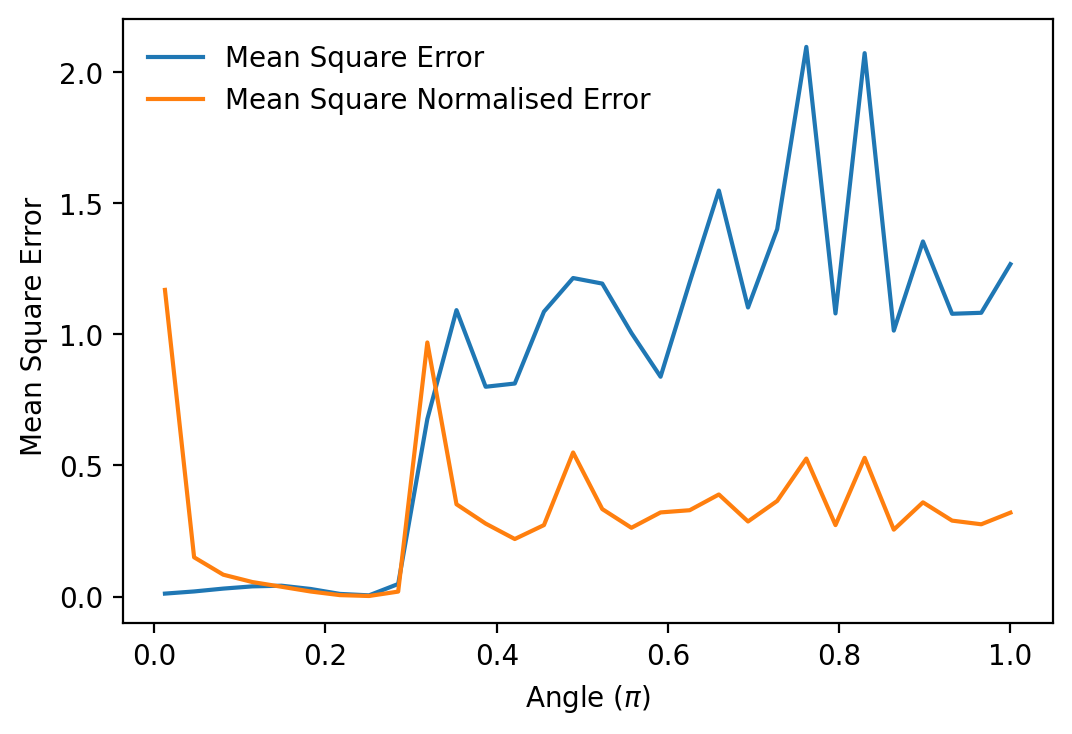

In [25]:
angles=np.linspace(np.pi/80,np.pi,30)
Nang=len(angles)
mse=np.zeros(Nang)
msen=np.zeros(Nang)
for ia in tqdm(range(Nang)):
    z0=[angles[ia],0,angles[ia],0]
    t,x1,y1,x2,y2=getTXY(z0,tmax,dt)
    data=np.vstack([x2,y2]).T
    train_data,val_data,test_data,train_label,val_label,test_label=getTestTrainVal(data,windowsize,offset)
    test_predict=model.predict(test_data)
    mse[ia]=getMSE(test_predict,test_label)
    msen[ia]=getMSENorm(test_predict,test_label)
fig,ax=plt.subplots()
ax.plot(angles/np.pi,mse,label="Mean Square Error")
ax.plot(angles/np.pi,msen,label="Mean Square Normalised Error")
ax.set_xlabel ('Angle ($\pi$)')
ax.set_ylabel ('Mean Square Error ')
ax.legend()

  0%|          | 0/10 [00:00<?, ?it/s]

[ 1 11 21 31 41 51 61 71 81 91]
(1001, 2)


100%|██████████| 10/10 [11:35<00:00, 69.54s/it]


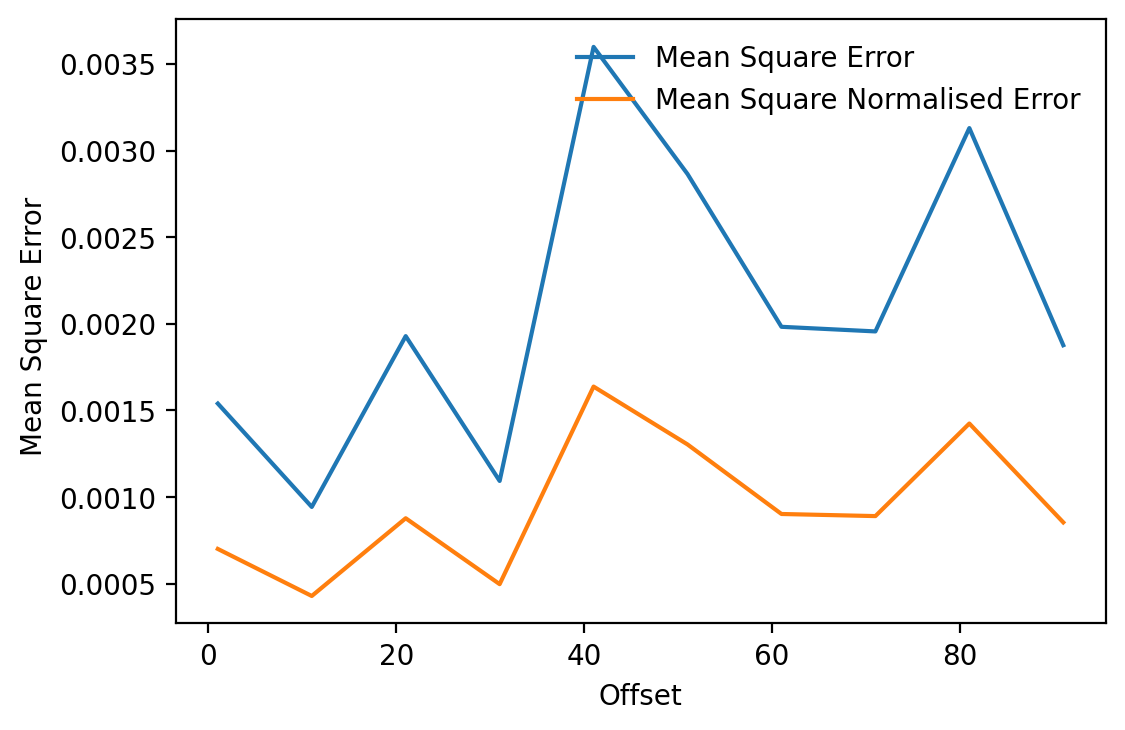

In [26]:
offsets=np.arange(1,101,10)
Noff=len(offsets)
print(offsets)
mse=np.zeros(Noff)
msen=np.zeros(Noff)

z0=[np.pi/4,0,np.pi/4,0]
tmax, dt = 100, 0.1
t,x1,y1,x2,y2=getTXY(z0,tmax,dt)
data=np.vstack([x2,y2]).T
print(data.shape)

windowsize=50 #Number of samples we will use to train our network

for ioff in tqdm(range(Noff)):
    offset=offsets[ioff] #How many samples into the future to predict
    train_data,val_data,test_data,train_label,val_label,test_label=getTestTrainVal(data,windowsize,offset)
    model=create_model(2)
    history=model.fit(train_data,train_label,epochs=30,batch_size=8,verbose=0,validation_data=(val_data,val_label))
    test_predict=model.predict(test_data)
    mse[ioff]=getMSE(test_predict,test_label)
    msen[ioff]=getMSENorm(test_predict,test_label)
    

fig,ax=plt.subplots()
ax.plot(offsets,mse,label="Mean Square Error")
ax.plot(offsets,msen,label="Mean Square Normalised Error")
ax.set_xlabel ('Offset')
ax.set_ylabel ('Mean Square Error ')
ax.legend()

## $z0=[\pi/2,0,\pi/2,0]$
Probably I should have functioned this all up. But there were enough little changes going from four to two variables that I just copied-and-pasted. Bad me!!

Epoch 1/80
78/78 [==============================] - 2s 28ms/step - loss: 0.7281 - val_loss: 0.6430
Epoch 2/80
78/78 [==============================] - 2s 22ms/step - loss: 0.6590 - val_loss: 0.5928
Epoch 3/80
78/78 [==============================] - 2s 26ms/step - loss: 0.6402 - val_loss: 0.6187
Epoch 4/80
78/78 [==============================] - 2s 24ms/step - loss: 0.6242 - val_loss: 0.5835
Epoch 5/80
78/78 [==============================] - 2s 23ms/step - loss: 0.6059 - val_loss: 0.5939
Epoch 6/80
78/78 [==============================] - 3s 34ms/step - loss: 0.5676 - val_loss: 0.5894
Epoch 7/80
78/78 [==============================] - 2s 27ms/step - loss: 0.5463 - val_loss: 0.5567
Epoch 8/80
78/78 [==============================] - 2s 27ms/step - loss: 0.5365 - val_loss: 0.5316
Epoch 9/80
78/78 [==============================] - 2s 26ms/step - loss: 0.4766 - val_loss: 0.5362
Epoch 10/80
78/78 [==============================] - 2s 26ms/step - loss: 0.4791 - val_loss: 0.5172
Epoch 11/

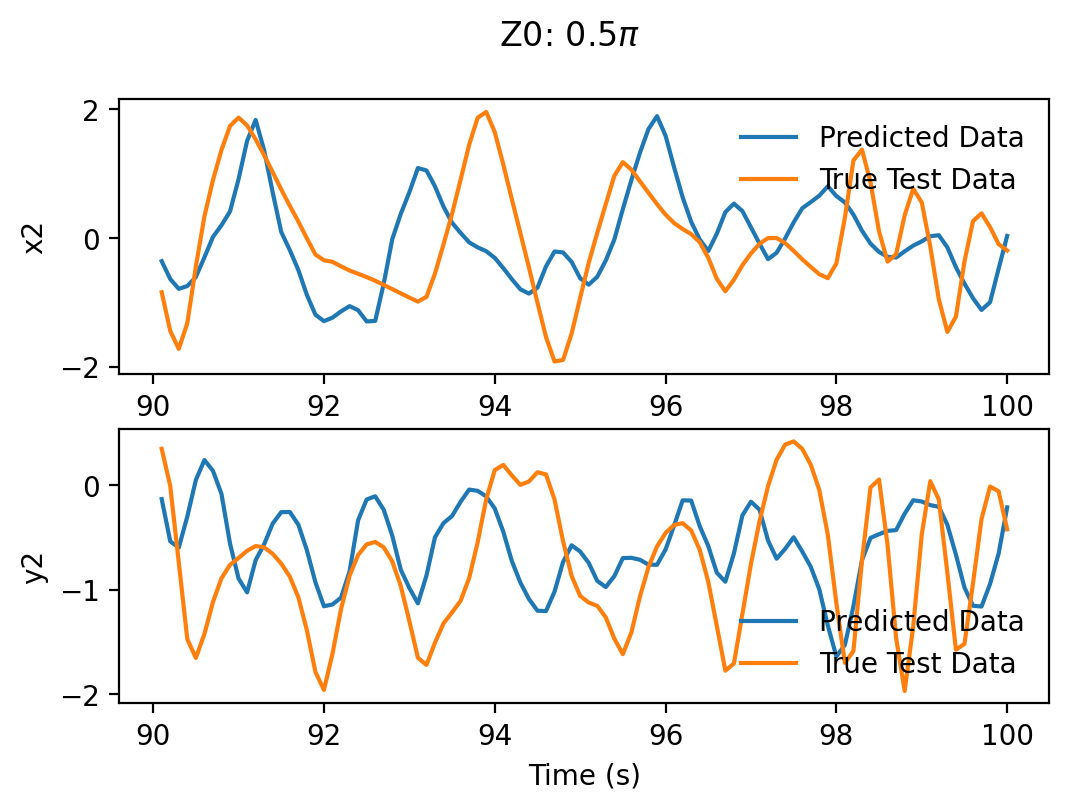

In [27]:
z0=[np.pi/2,0,np.pi/2,0]
tmax, dt = 100, 0.1
t,x1,y1,x2,y2=getTXY(z0,tmax,dt)
data=np.vstack([x2,y2]).T

offset=20
windowsize=50 #Number of samples we will use to train our network
train_data,val_data,test_data,train_label,val_label,test_label=getTestTrainVal(data,windowsize,offset)
model=create_model(2)
history=model.fit(train_data,train_label,epochs=80,batch_size=8,verbose=1,validation_data=(val_data,val_label))
test_predict=model.predict(test_data)
plotPredVsReal(test_predict,test_label,title="Z0: "+str(z0[0]/np.pi)+"$\pi$",num_vars=2)

100%|██████████| 8/8 [00:04<00:00,  1.75it/s]


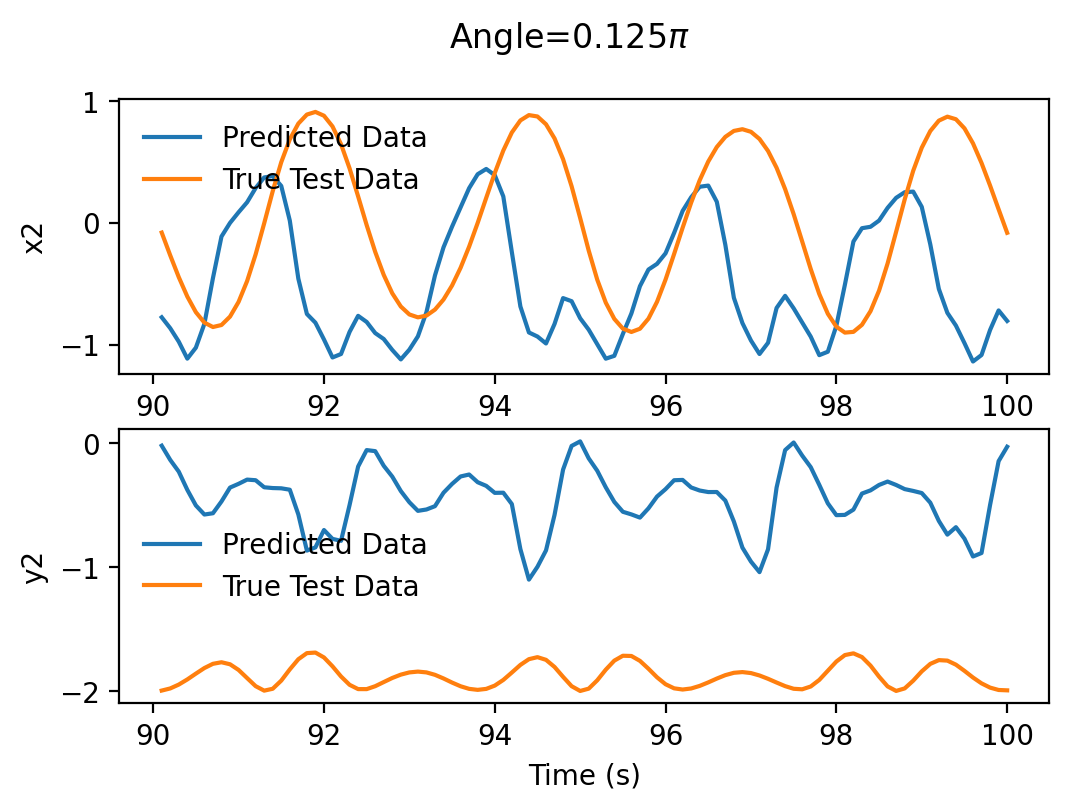

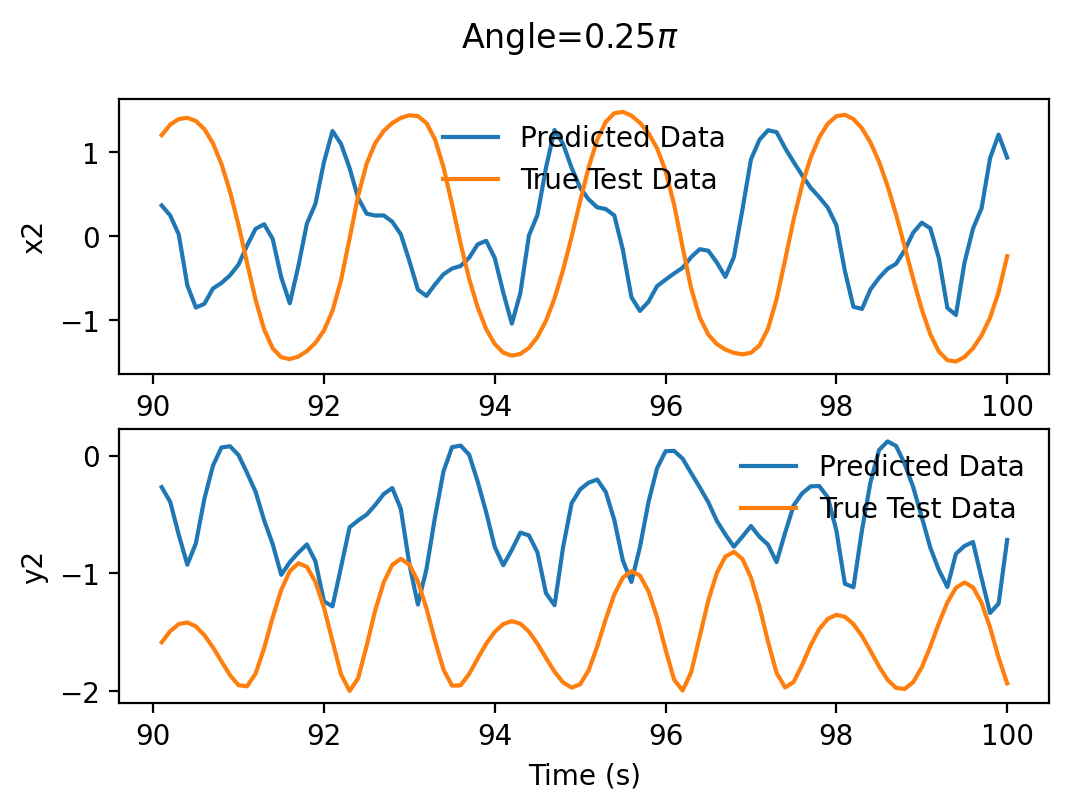

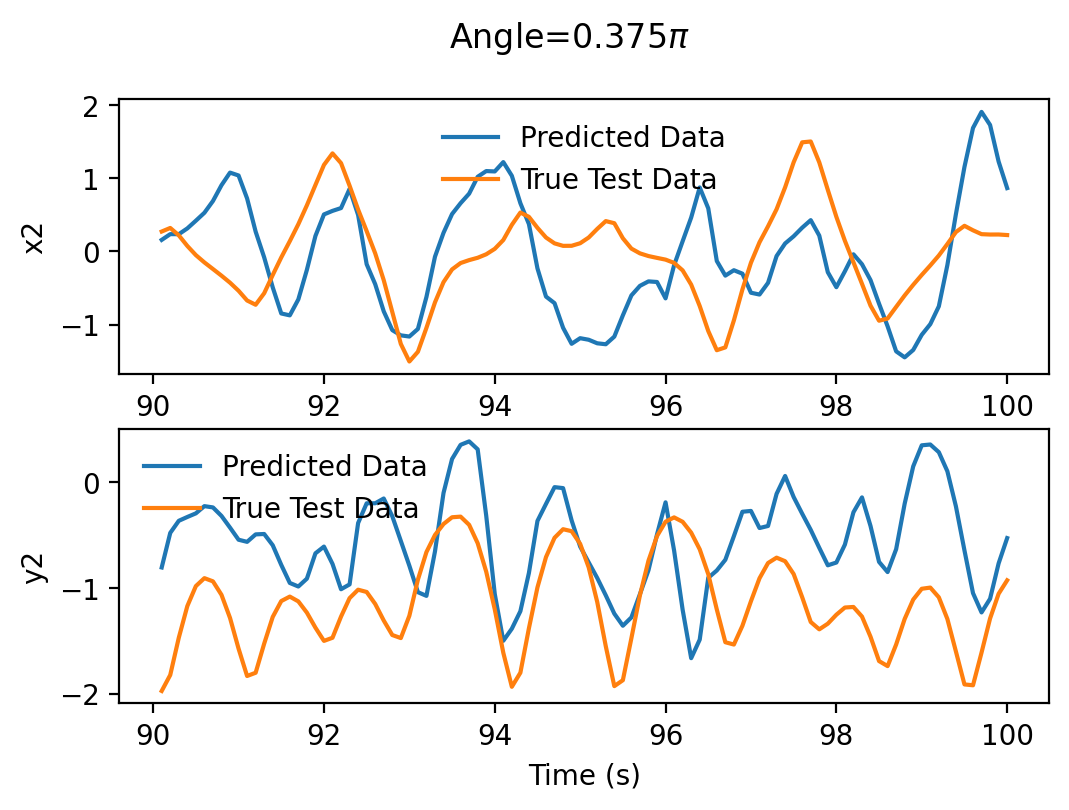

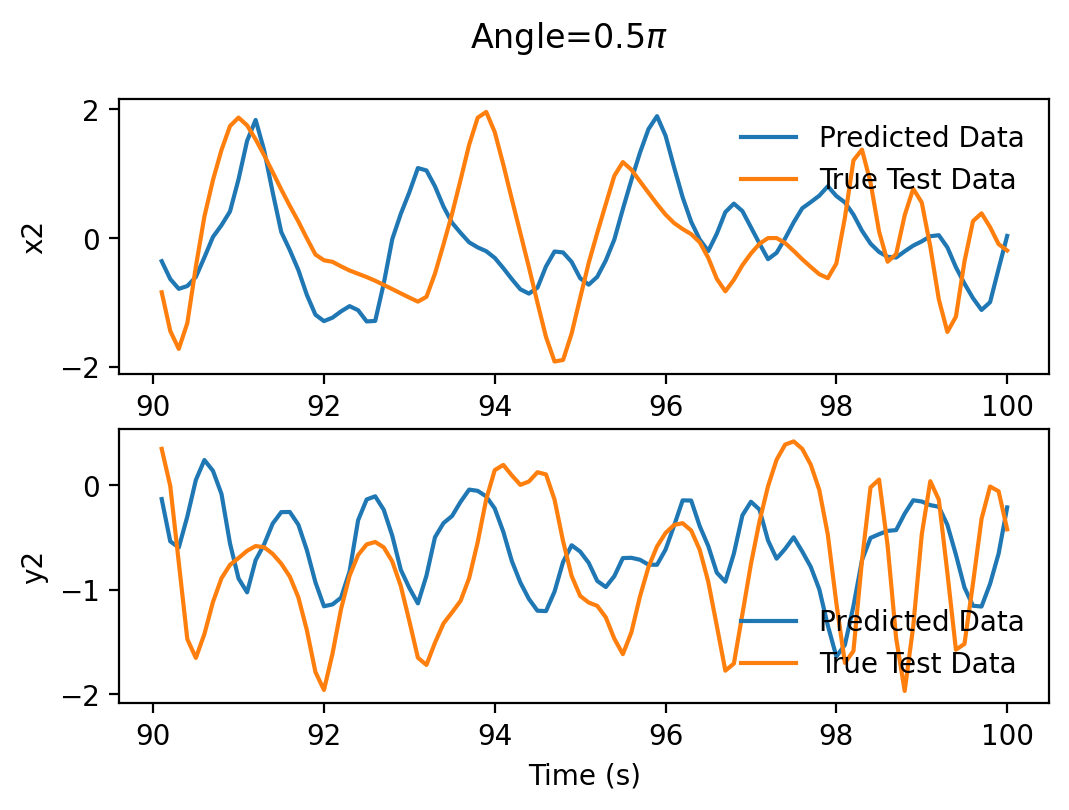

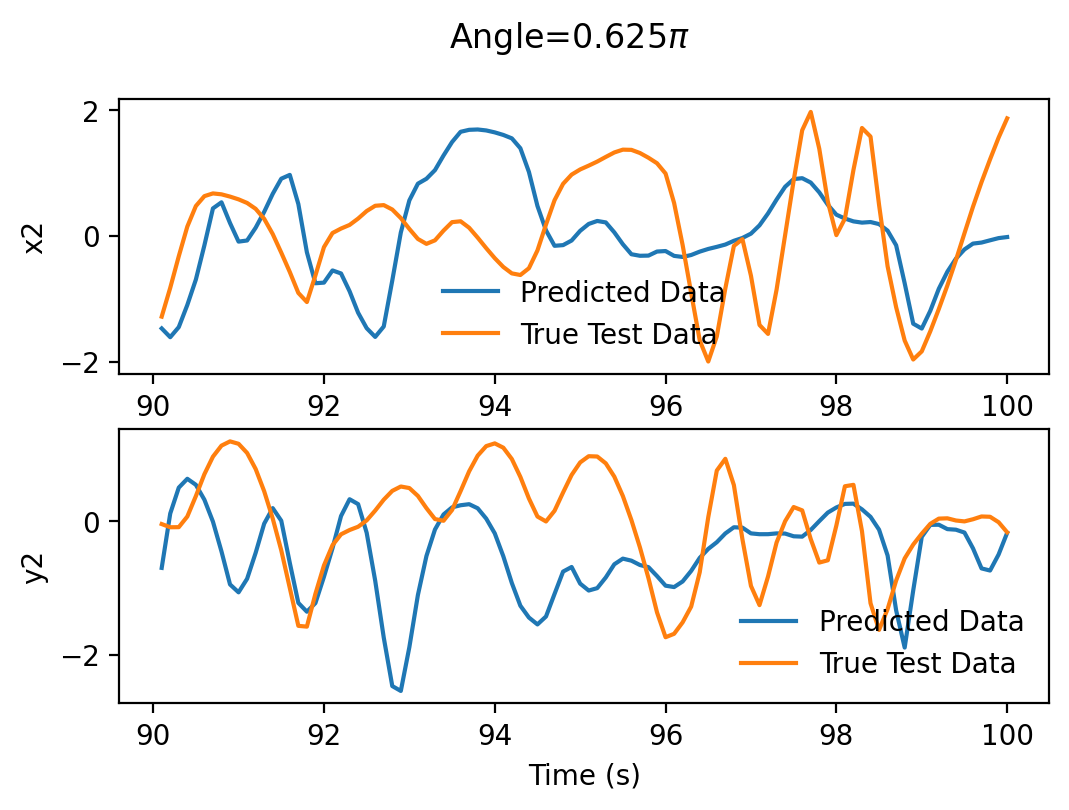

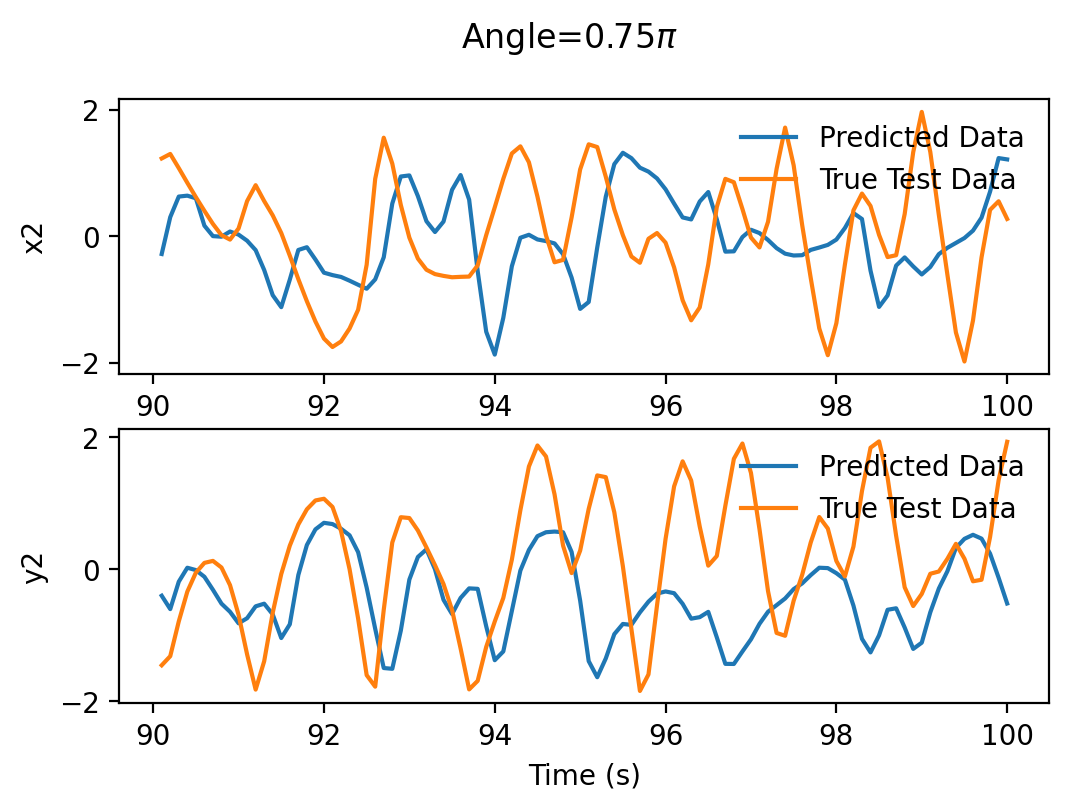

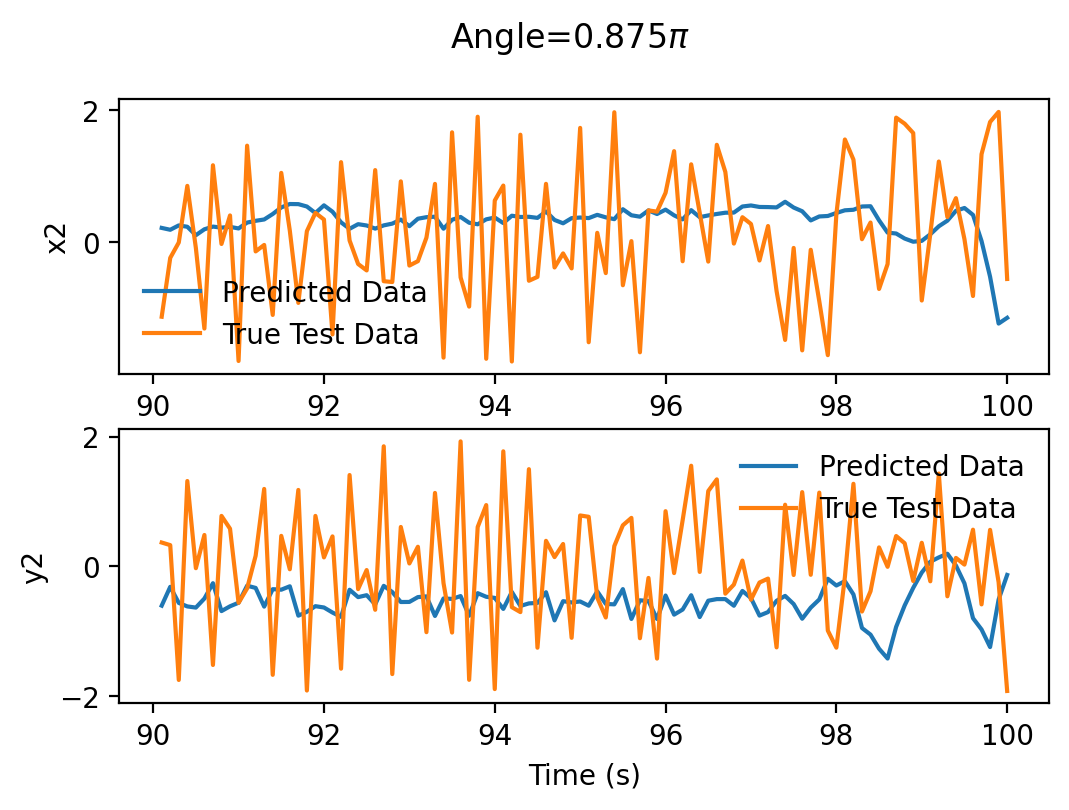

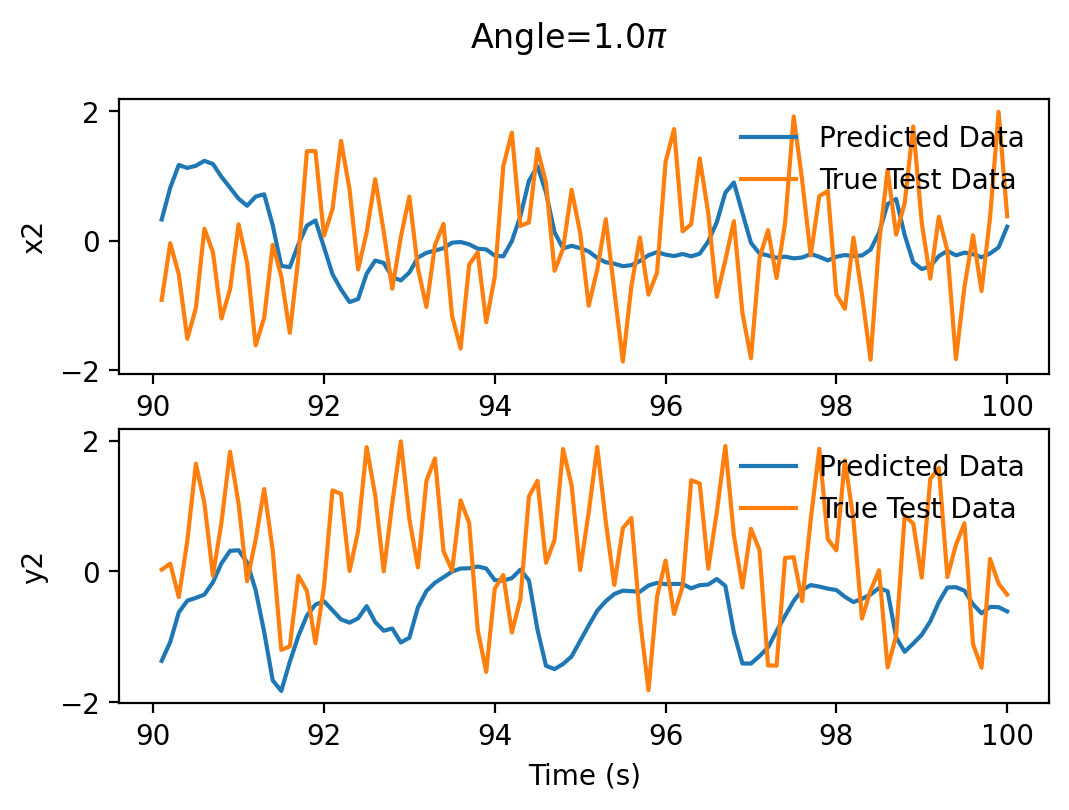

In [28]:
angles=np.linspace(np.pi/8,np.pi,8)
Nang=len(angles)

for ia in tqdm(range(Nang)):
    z0=[angles[ia],0,angles[ia],0]
    t,x1,y1,x2,y2=getTXY(z0,tmax,dt)
    data=np.vstack([x2,y2]).T
    train_data,val_data,test_data,train_label,val_label,test_label=getTestTrainVal(data,windowsize,offset)
    test_predict=model.predict(test_data)
    plotPredVsReal(test_predict,test_label,"Angle="+str(angles[ia]/np.pi)+"$\pi$",num_vars=2)

100%|██████████| 30/30 [00:32<00:00,  1.09s/it]


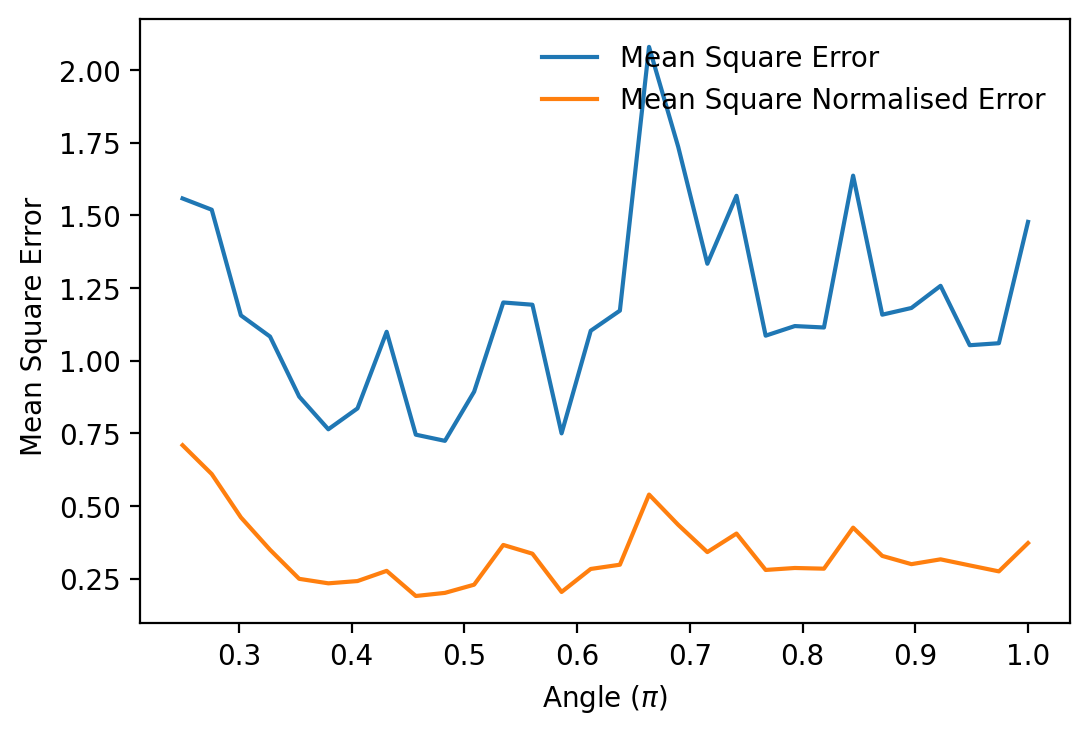

In [29]:
angles=np.linspace(np.pi/4,np.pi,30)
Nang=len(angles)
mse=np.zeros(Nang)
msen=np.zeros(Nang)
for ia in tqdm(range(Nang)):
    z0=[angles[ia],0,angles[ia],0]
    t,x1,y1,x2,y2=getTXY(z0,tmax,dt)
    data=np.vstack([x2,y2]).T
    train_data,val_data,test_data,train_label,val_label,test_label=getTestTrainVal(data,windowsize,offset)
    test_predict=model.predict(test_data)
    mse[ia]=getMSE(test_predict,test_label)
    msen[ia]=getMSENorm(test_predict,test_label)
fig,ax=plt.subplots()
ax.plot(angles/np.pi,mse,label="Mean Square Error")
ax.plot(angles/np.pi,msen,label="Mean Square Normalised Error")
ax.set_xlabel ('Angle ($\pi$)')
ax.set_ylabel ('Mean Square Error ')
ax.legend()

[ 1 11 21 31 41 51 61 71 81 91]


  0%|          | 0/10 [00:00<?, ?it/s]

(1001, 2)


100%|██████████| 10/10 [28:44<00:00, 172.46s/it]


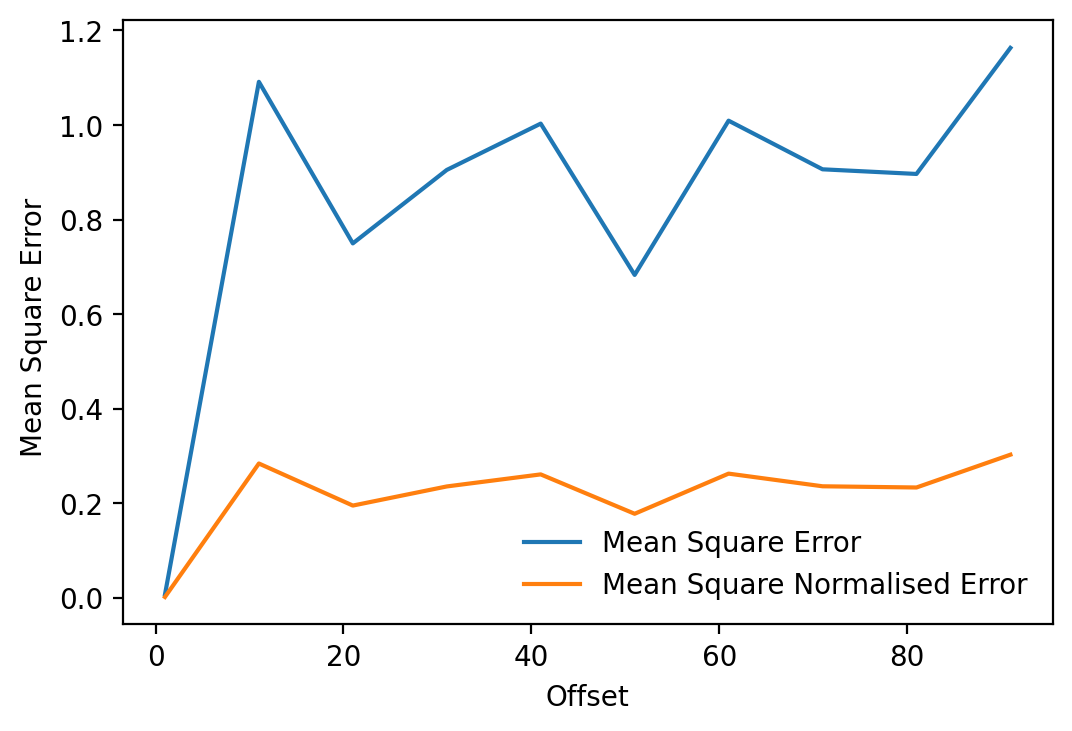

In [30]:
offsets=np.arange(1,101,10)
Noff=len(offsets)
print(offsets)
mse=np.zeros(Noff)
msen=np.zeros(Noff)

z0=[np.pi/2,0,np.pi/2,0]
tmax, dt = 100, 0.1
t,x1,y1,x2,y2=getTXY(z0,tmax,dt)
data=np.vstack([x2,y2]).T
print(data.shape)

windowsize=50 #Number of samples we will use to train our network

for ioff in tqdm(range(Noff)):
    offset=offsets[ioff] #How many samples into the future to predict
    train_data,val_data,test_data,train_label,val_label,test_label=getTestTrainVal(data,windowsize,offset)
    model=create_model(2)
    history=model.fit(train_data,train_label,epochs=80,batch_size=8,verbose=0,validation_data=(val_data,val_label))
    test_predict=model.predict(test_data)
    mse[ioff]=getMSE(test_predict,test_label)
    msen[ioff]=getMSENorm(test_predict,test_label)
    

fig,ax=plt.subplots()
ax.plot(offsets,mse,label="Mean Square Error")
ax.plot(offsets,msen,label="Mean Square Normalised Error")
ax.set_xlabel ('Offset')
ax.set_ylabel ('Mean Square Error ')
ax.legend()